In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

In [2]:
df = pd.read_csv('../../../data_set/train-data.csv', index_col=0)

Prima di tutto osserviamo la panoramica generale del dataset

In [3]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


Già notiamo la mancanza di uniformità nelle unità di misura della feature Mileage, probabilmente dovuta al carburante differente. Per comprendere a pieno la natura delle features:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


Quello che risalta subito all'occhio sono i missing values (NaN) in più di qualche features, dovremmo tenerne conto  

**Dizionario dei dati**  
Name: marchio + modello. E' qualitativa, e si potrebbe estrarre la marca.  
Location: altra variabile categorica, che descrive la città o la regione in cui l'auto è in vendita.   
Year: l'anno di produzione del modello. Numerica, discreta, scala a intervalli. Si potrebbe derivare l'età dell'auto.  
Kilometers_Driven: i chilometri totali percorsi dall'auto. Numerica, continua, scala ratio. Unità di misura: km.    
Fuel_type: tipo carburante. Categorica.  
Transmission: categorica binaria. Descrizione: automatica o manuale.  
Owner_Type: categorica ed ordinale perché "Firsthand" ha un valore maggiore.   
Mileage: indica il consumo di carburante, è numerica e continua, scala ratio, anche se in realtà non può consumare 0. Unità di misura: kmpl, km/kg.  
Engine: cilindrata del motore. E' numerica e continua, scala ratio. Unità di misura: cc.   
Power: la potenza massima del motore in bhp, è numerica e continua, scala ratio. Unità di misura: bhp.  
Seats: numero di posti a sedere, è numerica e discreta, ratio. Potrebbe definire la categoria del veicolo (SUV, monovolume ecc...)  
New_Price: il prezzo dell'auto nuova dello stesso modello. Numerica, continua, ratio. Valuta: INR Lakhs.  
Price: variabile target, è il prezzo di vendita dell'auto usata. Numerica, continua, ratio. Essendo una variabile continua, il problema da risolvere è un problema di regressione. Valuta: INR Lakhs.  

**Definizione degli obiettivi dell’analisi dei dati**  
Quali sono i fattori principali che determinano il prezzo (Price) di un'auto usata?  
In che modo l'età dell'auto (derivata da Year) e i chilometri percorsi (Kilometers_Driven) interagiscono nel definire il valore?  
Quale impatto hanno le caratteristiche tecniche come il tipo di carburante (Fuel_Type) e la Transmission sul prezzo?    
Esistono marche (estratte da Name) o località (Location) specifiche in cui le auto mantengono meglio il loro valore?  


**Pulizia e Preprocessing**  
Iniziamo capendo con quanti NaN abbiamo a che fare, e come gestirli.

In [5]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [6]:
for x in df:
    if df[x].isnull().sum() > 0:
        print(f"Percentuale di NaN in {x}: ", (df[x].isnull().sum()/df[x].size)*100, "%")


Percentuale di NaN in Mileage:  0.033228110981890685 %
Percentuale di NaN in Engine:  0.5981059976740323 %
Percentuale di NaN in Power:  0.5981059976740323 %
Percentuale di NaN in Seats:  0.6977903306197043 %
Percentuale di NaN in New_Price:  86.31001827546105 %


Prima di potere gestire questi valori mancanti dobbiamo sistemare un po' di cose. Intanto rimuoviamo le unità di misura e trasformiamo alcune colonne in numeriche.

La gestione della colonna Mileage è particolare, in quanto abbiamo due unità di misura differenti a seconda del carburante, naturalmente dobbiamo uniformare ad una sola unità di misura. Intanto controlliamo tutte le possibili unità di misura:

In [7]:
# mileage_units = df['Mileage'].str.split().str[-1]
# mileage_units.unique()

---

Inizio modifica di ciccio

Questo accade perché tipicamente, per calcolare la quantità carburante consumato al chilometro, si utilizzano propreità diverse in base al tipo carburante dell'auto.

In genere:
- kmpl - chilometri al litro, usato per carburanti liquidi (benzina, diesel, GPL)
- km/kg - chilometri al chilogrammo, usato per carburanti diversi (CNG)

Vorremmo quindi, rimuovere o riempire i valori mancanti e sopratutto standardizzare le differenti unità di misura, in modo da averne solamente una.

Importante: ogni tipo di carburante ha una differente formula di conversione.

| Fuel     | Potere calorifico | Conversione (L → kg) approssimativa       |
| -------- | ----------------- | ----------------------------------------- |
| Petrol   | 32 MJ/l           | 1 L ≈ 0.74 kg (32/43 MJ/kg)               |
| Diesel   | 36 MJ/l           | 1 L ≈ 0.85 kg (36/42 MJ/kg)               |
| LPG      | 25 MJ/l           | 1 L ≈ ??? non serve, già espresso in km/kg |
| CNG      | 50 MJ/kg          | 1 L ≈ ??? non serve, già espresso in km/kg |
| Electric | -                 | non convertibile                          |

In [8]:
# df_clean2 = df.copy()

# df_clean2['Mileage_Unit'] = df_clean2['Mileage'].str.split(' ').str[1]

# expected_units = {
#     'Petrol': 'kmpl',
#     'Diesel': 'kmpl',
#     'LPG': 'km/kg',
#     'CNG': 'km/kg',
#     'Electric': None
# }

# def check_consistency(row):
#     expected = expected_units[row['Fuel_Type']]
#     actual = row['Mileage_Unit']
    
#     if row['Fuel_Type'] == 'Electric':
#         return pd.isna(actual)
    
#     return actual == expected

# df_clean2['Mileage_Consistent'] = df_clean2.apply(check_consistency, axis=1)

# consistency_report = (
#     df_clean2
#     .groupby('Fuel_Type')['Mileage_Consistent']
#     .value_counts()
#     .unstack(fill_value=0)
# )

# print(consistency_report)


In [9]:
# # Fattori di conversione da km/l a km/kg
# conversion_factors = {
#     'Petrol': 1/0.74,   # kmpl → km/kg
#     'Diesel': 1/0.85,   # kmpl → km/kg
#     'LPG': None,        # già km/kg
#     'CNG': None,        # già km/kg
#     'Electric': None    # ← RESTA NaN
# }

# def convert_to_kmpkg(row):
#     fuel = row['Fuel_Type']
#     value = row['Mileage_Value']
#     unit = row['Mileage_Unit']
    
#     # Valore mancante
#     if pd.isna(value):
#         return np.nan
    
#     # Electric → lasciamo NaN
#     if fuel == 'Electric':
#         return np.nan
    
#     # Se è già in km/kg → lascia così
#     if unit == 'km/kg':
#         return value
    
#     # Se è in kmpl → converti
#     factor = conversion_factors[fuel]
#     if unit == 'kmpl' and factor is not None:
#         return value / factor
    
#     return np.nan

# # Estrazione numeri e unità in colonne separate
df['Mileage'] = df['Mileage'].str.split(' ').str[0]
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

# df['Mileage_Unit'] = df['Mileage'].str.split(' ').str[1]

# # Applico la conversione
# df['Mileage_kmpkg'] = df.apply(convert_to_kmpkg, axis=1)

# median_value = df['Mileage_kmpkg'].median()
# df['Mileage_kmpkg'] = df['Mileage_kmpkg'].fillna(median_value)

# # Rendo Mileage definitivo
# df['Mileage'] = df['Mileage_kmpkg']

# df.drop(columns=['Mileage_kmpkg', 'Mileage_Value', 'Mileage_Unit'], inplace=True)

# df.head()

Fine modifica di ciccio

---

In [10]:
df['Power'] = df['Power'].str.split(' ').str[0]
df['Power'] = pd.to_numeric(df['Power'], errors='coerce')

In [11]:
df['New_Price'] = df['New_Price'].str.split(' ').str[0]
df['New_Price'] = pd.to_numeric(df['New_Price'], errors='coerce')

In [12]:
df['Engine'] = df['Engine'].str.split(' ').str[0]
df['Engine'] = pd.to_numeric(df['Engine'], errors='coerce')

In [13]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    float64
 12  Price              6019 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 658.3+ KB


Ora controlliamo i valori di ogni singola colonna, per capire se fanno parte del dominio. Ad esempio non può esserci un auto con 0 posti.

In [15]:
print(df["Location"].unique())

['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad']


In [16]:
unique_values = df['Year'].unique()
bad_values = unique_values[(unique_values <= 0) | (unique_values >= 2025)]
print(bad_values)

[]


In [17]:
unique_values = df['Kilometers_Driven'].unique()
bad_values = unique_values[(unique_values <= 0)]
print(bad_values)

[]


In [18]:
print(df["Fuel_Type"].unique())

['CNG' 'Diesel' 'Petrol' 'LPG' 'Electric']


In [19]:
print(df["Transmission"].unique())

['Manual' 'Automatic']


In [20]:
print(df["Owner_Type"].unique())

['First' 'Second' 'Fourth & Above' 'Third']


In [21]:
unique_values = df['Mileage'].unique()
bad_values = unique_values[(unique_values <= 0)]
print(bad_values)

[0.]


In [22]:
bad_values = df.loc[df['Mileage'] <= 0, 'Mileage']
print(bad_values.value_counts())

Mileage
0.0    68
Name: count, dtype: int64


In [23]:
print(df['Engine'].unique())

[ 998. 1582. 1199. 1248. 1968.  814. 1461. 2755. 1598. 1462. 1497. 2179.
 2477. 1498. 2143. 1995. 1984. 1197. 2494. 1798. 2696. 2698. 1061. 1198.
 2987.  796.  624. 1999. 1991. 2694. 1120. 2498.  799. 2393. 1399. 1796.
 2148. 1396. 1950. 4806. 1998. 1086. 1193. 2982. 1493. 2967. 2993. 1196.
 1799. 2497. 2354. 1373. 2996. 1591. 2894. 5461. 1595.  936. 1997.   nan
 1896. 1390. 1364. 2199.  993.  999. 1405. 2956. 1794.  995. 2496. 1599.
 2400. 1495. 2523.  793. 4134. 1596. 1395. 2953. 1586. 2362. 1496. 1368.
 1298. 1956. 1299. 3498. 2835. 1150. 3198. 1343. 1499. 1186. 1590. 2609.
 2499. 2446. 1978. 2360. 3436. 2198. 4367. 2706. 1422. 2979. 1969. 1489.
 2489. 1242. 1388. 1172. 2495. 1194. 3200. 1781. 1341. 2773. 3597. 1985.
 2147. 1047. 2999. 2995. 2997. 1948. 2359. 4395. 2349. 2720. 1468. 3197.
 2487. 1597. 2771.   72. 4951.  970. 2925. 2200. 5000. 2149. 5998. 2092.
 5204. 2112. 1797.]


In [24]:
unique_values = df['Power'].unique()
bad_values = unique_values[(unique_values <= 0)]
print(bad_values)

[]


In [25]:
bad_values = df.loc[df['Seats'] <= 0, 'Seats']
print(bad_values.value_counts())

Seats
0.0    1
Name: count, dtype: int64


In [26]:
bad_values = df.loc[df['New_Price'] <= 0, 'New_Price']
print(bad_values.value_counts())

Series([], Name: count, dtype: int64)


In [27]:
bad_values = df.loc[df['Price'] <= 0, 'Price']
print(bad_values.value_counts())

Series([], Name: count, dtype: int64)


Notiamo che è tutto corretto tranne un elemento in Seats e 68 in Mileage. Potremmo semplicemente considerarli come dei NaN e gestirli come tali.

Ora possiamo gestire i NaN, abbiamo intenzione di imputare con la mediana, perché essendo un dataset con prezzi d'auto, potrebbe essere asimmetrica la distribuzione, quindi vogliamo optare per una scelta più robusta e sicura. (Mileage aspettare conversione di unità). Infine abbiamo deciso di droppare la colonna New_Price, in quanto ben l'86% dei dati è un valore NaN, e provare ad imputare creerebbe solo che rumore.

Percentuale di NaN in Mileage:  0.033228110981890685 %
Percentuale di NaN in Engine:  0.5981059976740323 %
Percentuale di NaN in Power:  0.5981059976740323 % 
Percentuale di NaN in Seats:  0.6977903306197043 % (0)
Percentuale di NaN in New_Price:  86.31001827546105 %



In [28]:
df = df.drop('New_Price', axis=1)

In [29]:
cols_to_impute = ['Power', 'Mileage', 'Engine', 'Seats']
df[cols_to_impute] = df[cols_to_impute].replace(0.0, np.nan)

for col in cols_to_impute:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [30]:
df['Engine'] = df['Engine'].astype('int64');
df['Seats'] = df['Seats'].astype('int64');

Abbiamo corretto gli ultimi Dtype.

La colonna name vorremmo fosse più rappresentativa, per questo motivo vorremo modificarle in due colonne una "Brand", e una "Model".

In [31]:
df['Brand'] = df['Name'].str.split(' ').str[0]
df['Model'] = df['Name'].str.split(' ').str[1]
df = df.drop('Name', axis=1)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Mileage            6019 non-null   float64
 7   Engine             6019 non-null   int64  
 8   Power              6019 non-null   float64
 9   Seats              6019 non-null   int64  
 10  Price              6019 non-null   float64
 11  Brand              6019 non-null   object 
 12  Model              6019 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 658.3+ KB


In [34]:
first_cols = ['Brand', 'Model']

remaining_cols = [col for col in df.columns if col not in first_cols]

df = df[first_cols + remaining_cols]
df.head()
df.head()

,Brand,Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Wagon,Mumbai,2010,72000,CNG,Manual,First,26.60,998,58.16,5,1.75
1,Hyundai,Creta,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.20,5,12.50
2,Honda,Jazz,Chennai,2011,46000,Petrol,Manual,First,18.20,1199,88.70,5,4.50
3,Maruti,Ertiga,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7,6.00
4,Audi,A4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968,140.80,5,17.74


Verifichiamo che non ci siano errori di battitura o altro

In [35]:
df['Brand'].value_counts()

Brand
Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Smart               1
Isuzu               1
Ambassador          1
Bentley             1
Lamborghini         1
Name: count, dtype: int64

In [36]:
df['Model'].unique()

array(['Wagon', 'Creta', 'Jazz', 'Ertiga', 'A4', 'EON', 'Micra', 'Innova',
       'Vento', 'Indica', 'Ciaz', 'City', 'Swift', 'Rover', 'Pajero',
       'Amaze', 'Duster', 'New', '3', 'S', 'A6', 'i20', 'Alto', 'WRV',
       'Corolla', 'Ssangyong', 'Vitara', 'KUV', 'M-Class', 'Polo', 'Nano',
       'Elantra', 'Xcent', 'Thar', 'Grand', 'KWID', 'i10', 'X-Trail',
       'Zen', 'Figo', 'C-Class', 'Cayenne', 'XUV500', 'Terrano', 'Brio',
       'Fiesta', 'Santro', 'Zest', 'Ritz', '5', 'Fortuner', 'Ecosport',
       'Verna', 'GO', 'Omni', 'Etios', 'XF', 'Eeco', 'Civic', 'V40', 'B',
       'Scorpio', 'CR-V', 'SLC', '1', 'Beat', 'Rapid', 'RS5', 'Superb',
       'X5', 'GLC', 'Countryman', 'Optra', 'Lodgy', 'E-Class', 'Baleno',
       'Laura', 'NuvoSport', 'Fabia', 'Indigo', 'Q3', 'Octavia', 'A8',
       'Verito', 'Cooper', 'Santa', 'X1', 'Accent', 'Tucson', 'GLE',
       'A-Star', 'Grande', 'X3', 'EcoSport', 'Q7', 'Jetta', 'GLA',
       'Celerio', 'Sumo', 'Accord', '6', 'Manza', 'Spark', 'Clubman'

Perfetto. Ora rimuoviamo eventuali righe duplicate

In [37]:
duplicate_count = df.duplicated().sum()

print(f"Ci sono {duplicate_count} righe duplicate.")

Ci sono 2 righe duplicate.


In [38]:
df.drop_duplicates(inplace=True)

Adesso passiamo alla gestione degli outliers. Prima di tutto, indentifichiamoli con gli appositi boxplot.

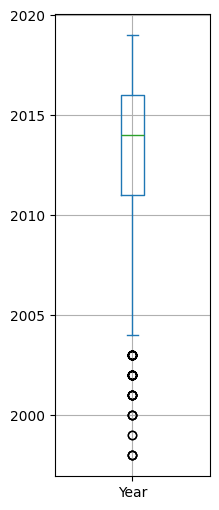

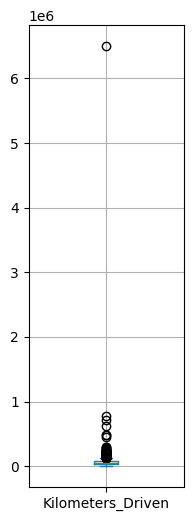

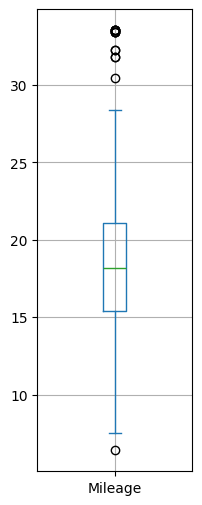

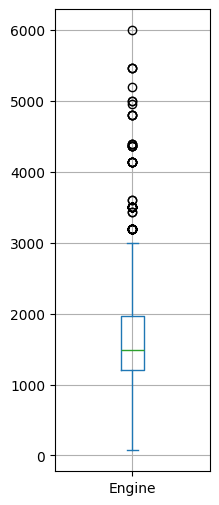

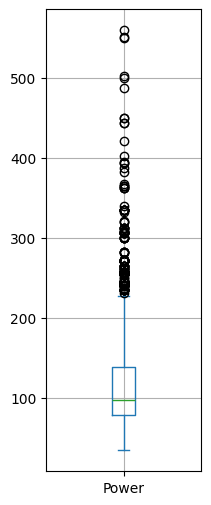

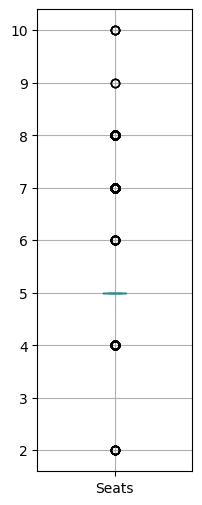

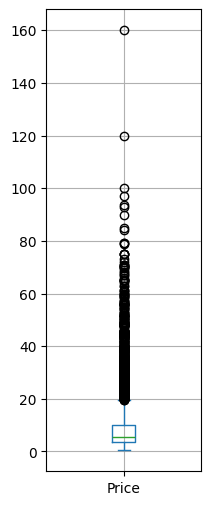

In [39]:
for x in ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']:
    df[x].plot.box(figsize=(2,6))
    plt.grid()
    plt.show()

Procediamo per ordine. Intanto notiamo che in Year non sembrerebbero molti gli outlier, quindi potremmo pure rimuoverli, questo poiché auto molto vecchie seguono normative differente, un mercato differente, il che potrebbe portare solo che confusione. Verifichiamo quanti sono:

In [39]:
threshold = 2005
auto_vecchie = df[df['Year'] < threshold]

print(f"Numero di auto prima del {threshold}: {len(auto_vecchie)}")
print(auto_vecchie[['Year', 'Brand', 'Price']].head())

Numero di auto prima del 2005: 81
     Year   Brand  Price
222  2004  Maruti   1.25
274  2002  Maruti   0.55
315  2000    Tata   1.50
336  2004  Toyota   2.50
364  2003  Maruti   0.65


Sono veramente poche, possiamo pure rimuoverle. Inoltre, guardando i prezzi (0.55 Lakh, 1.25 Lakh), queste auto appartengono a un mercato "di fine vita" che segue logiche molto diverse dal resto del dataset. Mantenerle rischierebbe solo di aggiungere rumore per i casi limite.

In [40]:
df = df[df['Year'] >= 2005]
df.reset_index(drop=True, inplace=True)

Ora passiamo a Kilometers, si nota subito quel numero spaventoso lì in alto, sicuramente impossibile. Sicuramente un errore. Meglio rimuoverlo. 

In [41]:
print("Outlier estremi (> 1 milione km):")
print(df[df['Kilometers_Driven'] > 1000000])

df = df[df['Kilometers_Driven'] < 1000000]
df.reset_index(drop=True, inplace=True)

Outlier estremi (> 1 milione km):
     Brand Model Location  Year  Kilometers_Driven Fuel_Type Transmission  \
2300   BMW    X5  Chennai  2017            6500000    Diesel    Automatic   

     Owner_Type  Mileage  Engine  Power  Seats  Price  
2300      First    15.97    2993  258.0      5   65.0  


Ora vogliamo ristampare il boxplot, poiché era poco comprensibile.

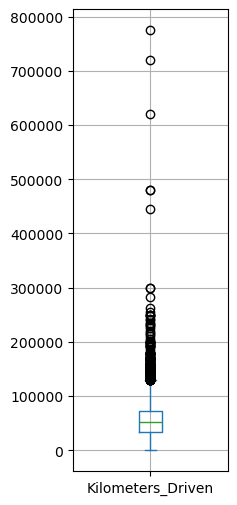

In [42]:
df['Kilometers_Driven'].plot.box(figsize=(2,6))
plt.grid()
plt.show()

Vogliamo sistemare questi outlier imputando il 99° percentile. Perché i valori sono troppo distanti, potrebbe portare solo che rumore al modello. Inoltre nel mercato odierno già sopra un tot chilometri sarebbero da rottamare le auto. Quindi potremmo usare il 99° percentile proprio per dire al modello di considerare l'auto massimamente usata, dato che dopo una certa soglia non c'è quasi nulla più da togliere. 

Soglia (99%): 170000 km


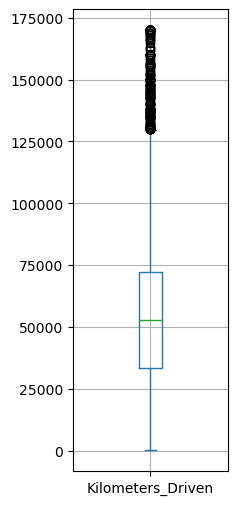

In [43]:
soglia_99 = df['Kilometers_Driven'].quantile(0.99)
print(f"Soglia (99%): {soglia_99:.0f} km")

df['Kilometers_Driven'] = np.where(df['Kilometers_Driven'] > soglia_99, 
                                   soglia_99, 
                                   df['Kilometers_Driven'])

df['Kilometers_Driven'].plot.box(figsize=(2,6))
plt.grid()
plt.show()

In Engine e Power non troviamo valori estremi, o impossibili, ma solo valori molto alti (probabilmente auto di lusso). Quindi corretto lasciare così.

Il boxplot di seats ci indica che probabilmente più del 90% del dataset ha 5 posti. Probabilmente anche per questo motivo viene considerato outlier qualsiasi numero non sia 5. Lasciamo tutto così, dato che è tutto perfettamente plausibile.

Per quanto riguarda Price, abbiamo una distribuzione right-skewed, il che è un problema per il nostro modello di regressione. Conviene fare una trasformazione logaritmica. Guardando il boxplot prima controlliamo se ci sono prezzi troppo bassi. 

In [44]:
price = df[df['Price'] < 0.5]
price

,Brand,Model,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
1693,Tata,Nano,Pune,2011,65000.0,Petrol,Manual,Second,26.0,624,35.0,4,0.44
2812,Hyundai,Getz,Pune,2005,86000.0,Petrol,Manual,Second,15.3,1341,83.0,5,0.45


In [45]:
df = df[df['Price'] >= 0.5]
df.reset_index(drop=True, inplace=True)

In [46]:
# df['Price_Log'] = np.log1p(df['Price'])

Facciamo plotting, per vedere la distribuzione.

In [47]:
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# sns.histplot(df['Price'], kde=True, ax=ax[0])
# ax[0].set_title('Distribuzione Originale (Asimmetrica)')

# sns.histplot(df['Price_Log'], kde=True, ax=ax[1])
# ax[1].set_title('Distribuzione Logaritmica (Simile a Campana)')

# plt.show()

In [48]:
# df.drop('Price', axis=1, inplace=True)
# df.rename(columns={'Price_Log': 'Price'}, inplace=True)


Abbiamo deciso di modificare la nostra variabile Year in Age, per questioni di semplicità, e per rappresentare meglio il deprezzamento o l'obsolescenza dell'auto.

In [49]:
max_year = df['Year'].max()
index_year = df.columns.get_loc('Year')
age_values = max_year - df['Year']
df.insert(index_year, 'Age', age_values)
df.drop('Year', axis=1, inplace=True)
df.head()

,Brand,Model,Location,Age,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti,Wagon,Mumbai,9,72000.0,CNG,Manual,First,26.60,998,58.16,5,1.75
1,Hyundai,Creta,Pune,4,41000.0,Diesel,Manual,First,19.67,1582,126.20,5,12.50
2,Honda,Jazz,Chennai,8,46000.0,Petrol,Manual,First,18.20,1199,88.70,5,4.50
3,Maruti,Ertiga,Chennai,7,87000.0,Diesel,Manual,First,20.77,1248,88.76,7,6.00
4,Audi,A4,Coimbatore,6,40670.0,Diesel,Automatic,Second,15.20,1968,140.80,5,17.74


Abbiamo pulito molto bene il dataset, adesso procediamo con la parte successiva. Per quanto comunque, è possibile, che in futuro ci siano nuove problematiche che ci porteranno a modificare passi precendenti, perché, come sappiamo, non è un processo perfettamente lineare.

Modifica di ciccio: salvo il dataframe

In [50]:
df.to_csv('dataframe.csv', index=False)

**Analisi Esplorativa**  
Iniziamo per ordine: Brand. Essendo che ci sono un po' di valori unici ha senso plottare solo i top. 


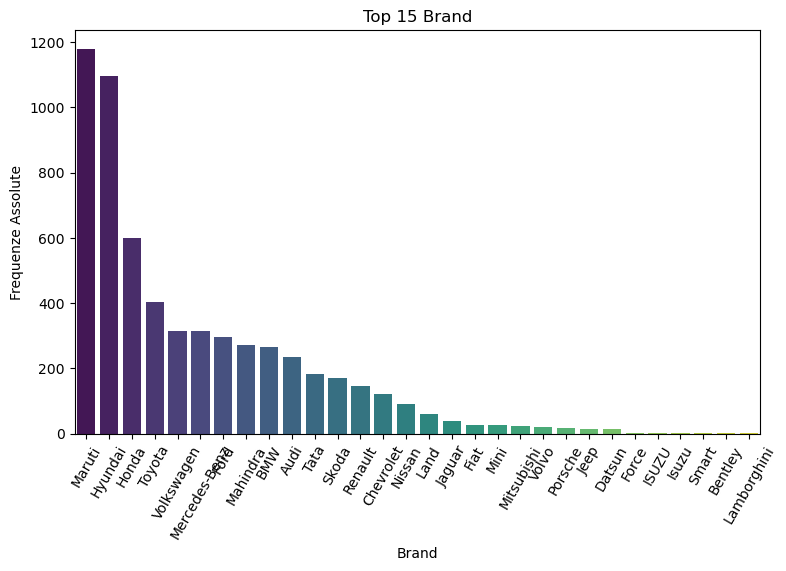

In [51]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
top_counts = df['Brand'].value_counts()
    
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette='viridis', legend=False)
plt.title('Top 15 Brand')
plt.xticks(rotation=60)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

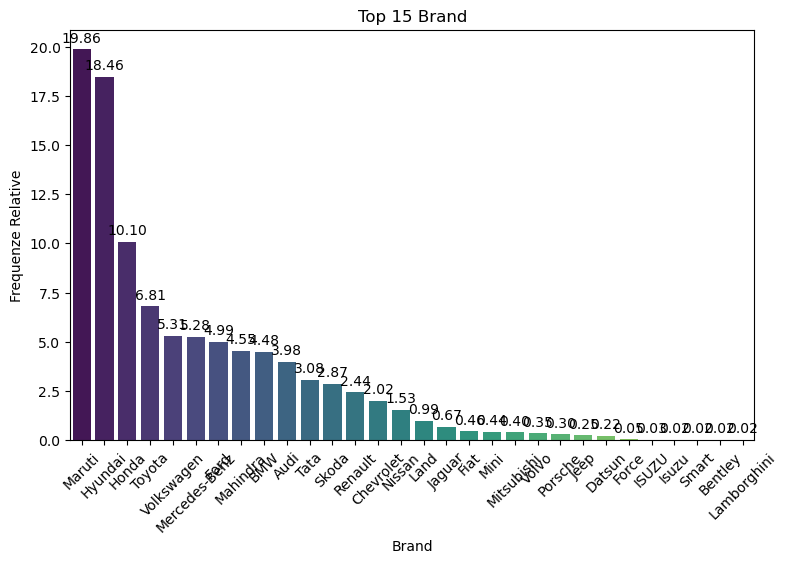

In [52]:
top_relative = df['Brand'].value_counts(normalize=True) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Top 15 Brand')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Essendoci marchi con pochi elementi potremmo creare due categorie: other_luxury e other. Due perché non vorremo che bentley, lambo ecc... vadano insieme a Smart, per non confondere il modello.

Il rischio per Model, è che ci siano troppi valori unici (207), il che potrebbe portare ad overplotting. Plottiamo solo i top 20:

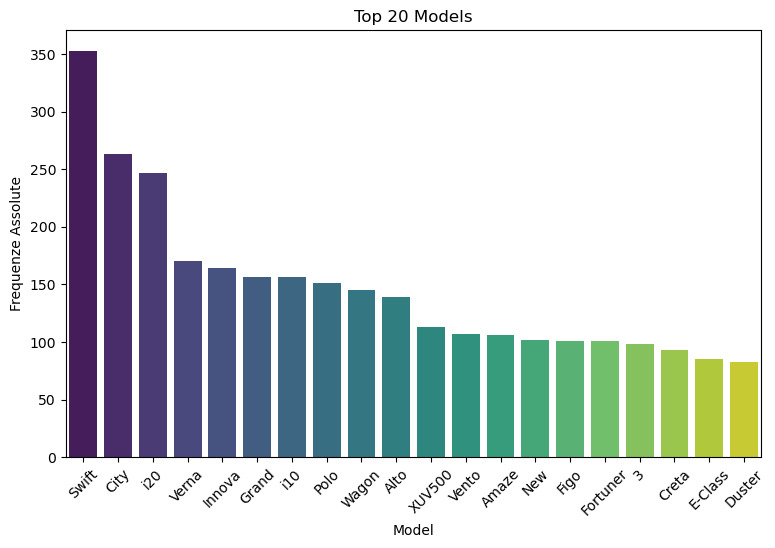

In [53]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

top_models = df['Model'].value_counts().head(20)

sns.barplot(x=top_models.index, y=top_models.values, palette='viridis', hue=top_models.index)

plt.title('Top 20 Models')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

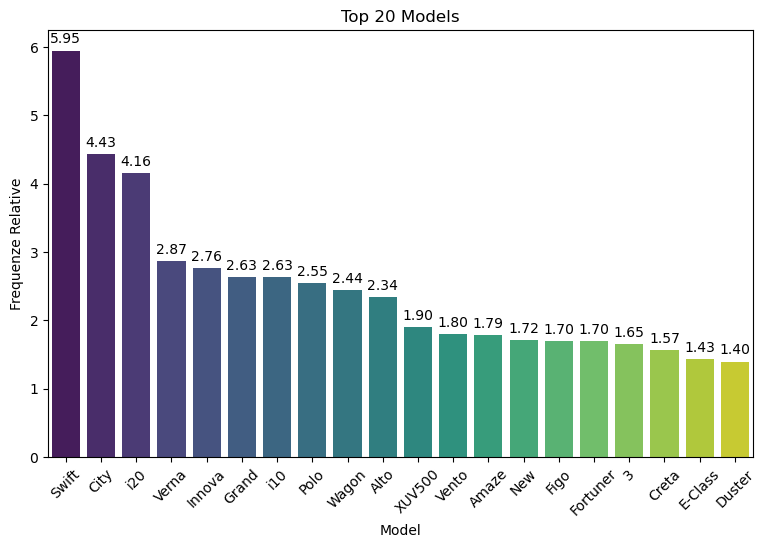

In [54]:
top_relative = df['Model'].value_counts(normalize=True).head(20) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Top 20 Models')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Molto variato. 207 valori unici sono troppi, si potrebbero prendere le categorie a frequenza molto piccola, e unire tutte in "other".

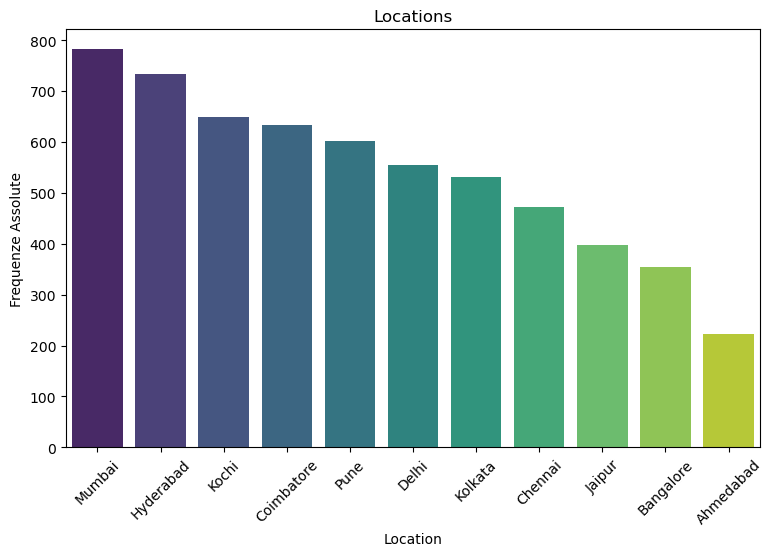

In [55]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

top_location = df['Location'].value_counts()

sns.barplot(x=top_location.index, y=top_location.values, palette='viridis', hue=top_location.index)

plt.title('Locations')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

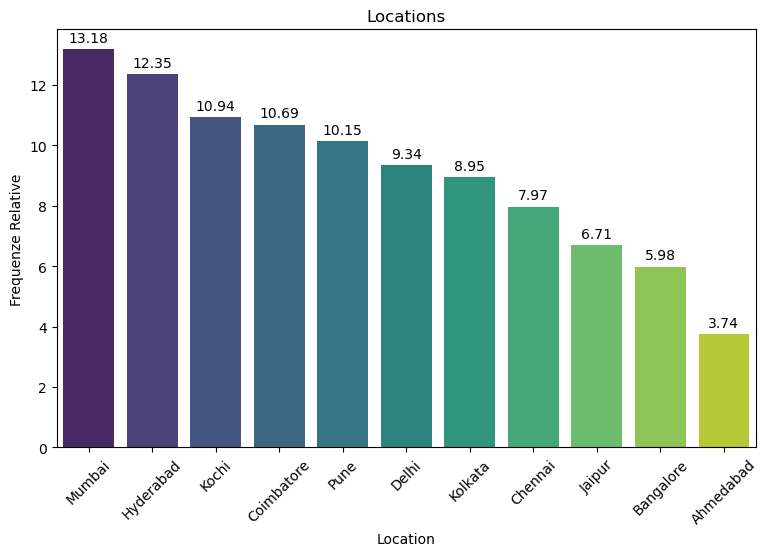

In [56]:
top_relative = df['Location'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Locations')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Notiamo subito che non c'è nessuna classe dominante, sono tutte più o meno lì. E' messa molto bene come variabile.

Age, essendo numerica ha senso chiedersi le misura di tendenza centrale e quelle di dispersione.

In [57]:
df['Age'].describe()

count    5933.000000
mean        5.491825
std         3.025650
min         0.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        14.000000
Name: Age, dtype: float64

In [58]:
df['Age'].mode()

0    5
Name: Age, dtype: int64

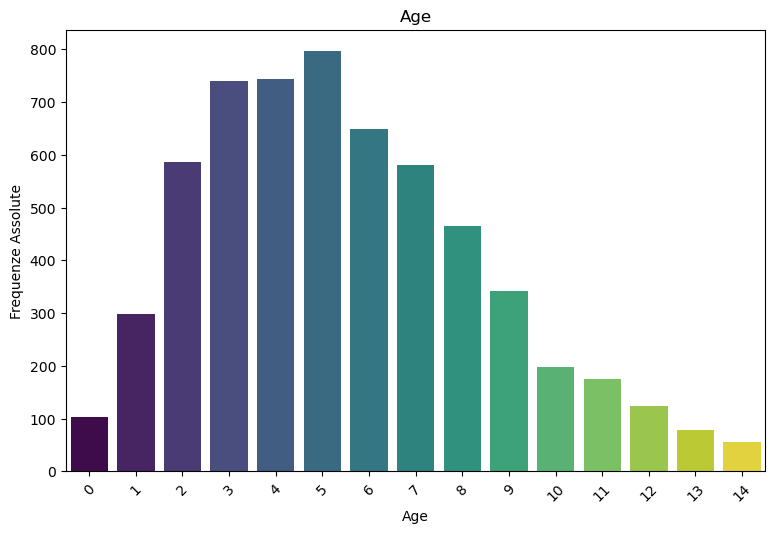

In [59]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

top_location = df['Age'].value_counts()

sns.barplot(x=top_location.index, y=top_location.values, palette='viridis', hue=top_location.index, legend=False)

plt.title('Age')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

Notiamo che la variabile tende a una distribuzione normale, il che ci piace.

In [60]:
df['Kilometers_Driven'].describe()

count      5933.000000
mean      56373.756447
std       31967.237578
min         171.000000
25%       33552.000000
50%       52576.000000
75%       72100.000000
max      170000.000000
Name: Kilometers_Driven, dtype: float64

In [61]:
df['Kilometers_Driven'].mode()

0    60000.0
Name: Kilometers_Driven, dtype: float64

Text(0.5, 1.0, 'Distribuzione di Kilometers_Driven')

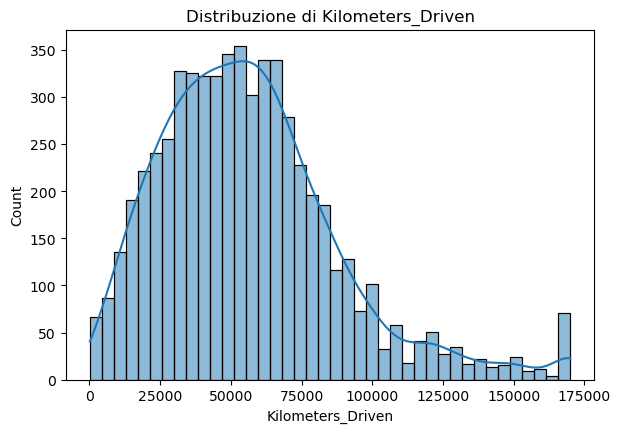

In [62]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.histplot(df['Kilometers_Driven'], kde=True)
plt.title('Distribuzione di Kilometers_Driven')

Anche questa variabile è veramente messa bene, e tende ad una gaussiana.

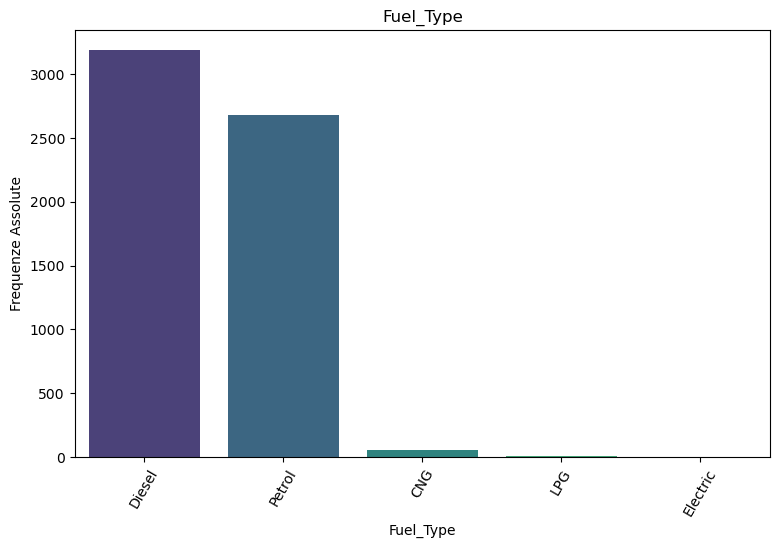

In [63]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
top_counts = df['Fuel_Type'].value_counts().head(15)
    
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette='viridis', legend=False)
plt.title('Fuel_Type')
plt.xticks(rotation=60)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

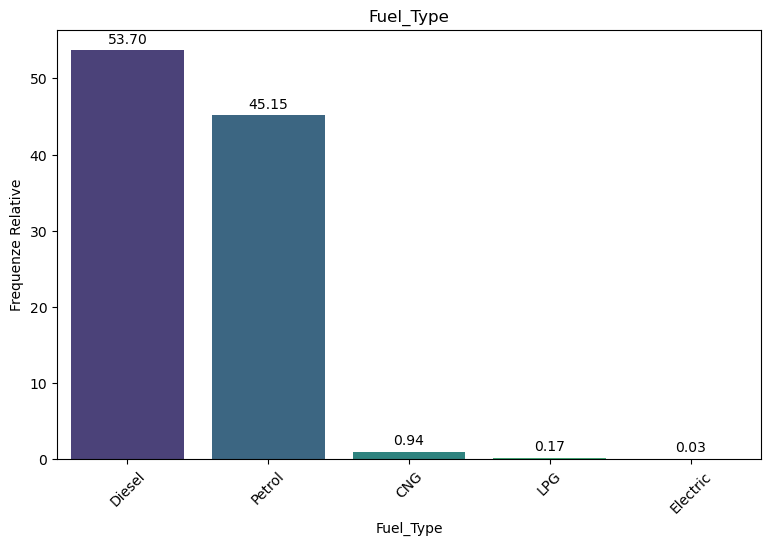

In [64]:
top_relative = df['Fuel_Type'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Fuel_Type')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

E' un duopolio Diesel e Benzina, molto probabilmente conviene rimuove CNG e LPG ed Electric (quest'ultima davvero insignificante) 

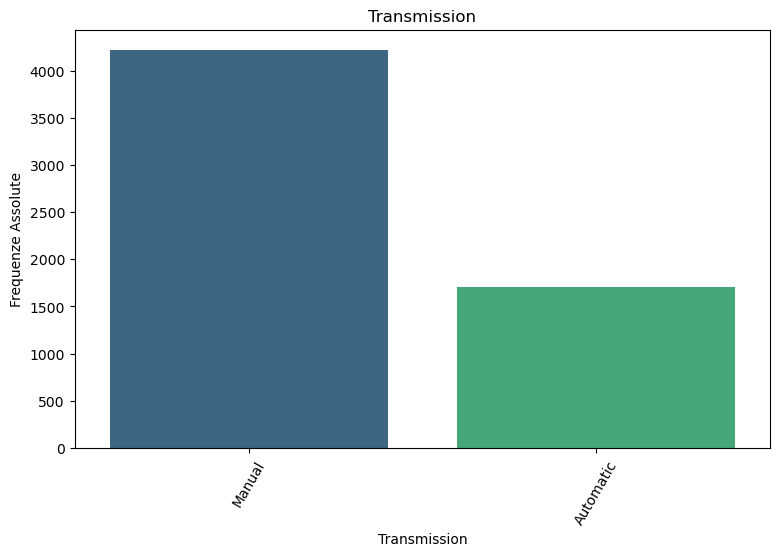

In [65]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
top_counts = df['Transmission'].value_counts().head(15)
    
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette='viridis', legend=False)
plt.title('Transmission')
plt.xticks(rotation=60)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

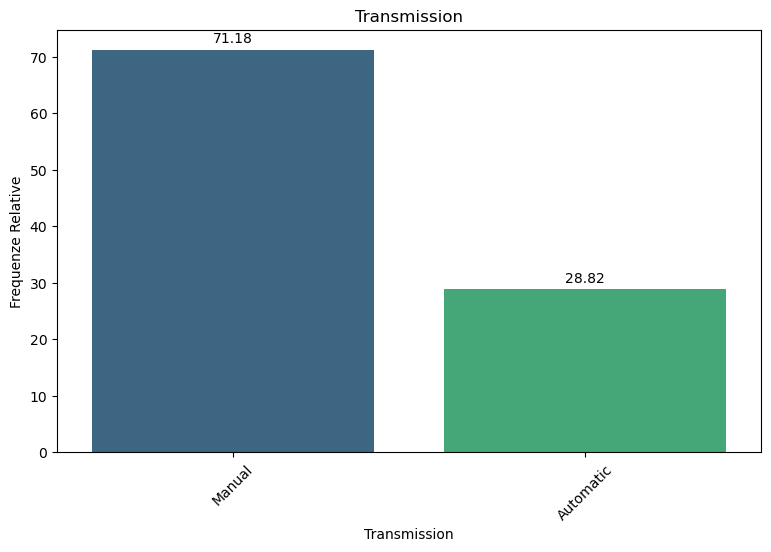

In [66]:
top_relative = df['Transmission'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Transmission')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Trasmission tutto ok.

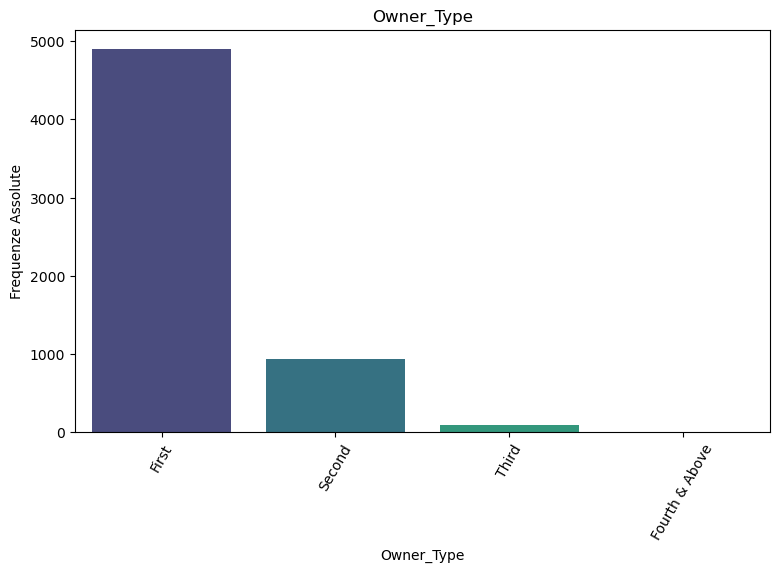

In [67]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
top_counts = df['Owner_Type'].value_counts().head(15)
    
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette='viridis', legend=False)
plt.title('Owner_Type')
plt.xticks(rotation=60)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

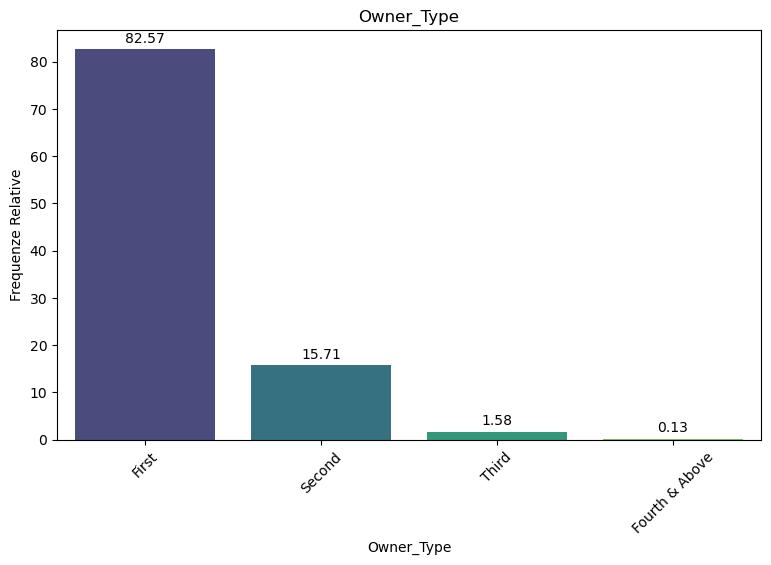

In [68]:
top_relative = df['Owner_Type'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Owner_Type')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Ricordiamo comunque essere ordinale come variabile. Conviene unire Fourth & Above con Third.

In [69]:
df['Mileage'].describe()

count    5933.000000
mean       18.373984
std         4.155028
min         6.400000
25%        15.400000
50%        18.200000
75%        21.100000
max        33.540000
Name: Mileage, dtype: float64

In [70]:
df['Mileage'].mode()

0    17.0
Name: Mileage, dtype: float64

Text(0.5, 1.0, 'Distribuzione di Mileage')

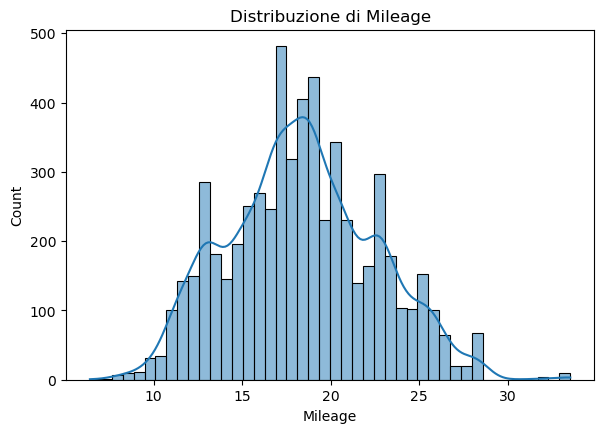

In [71]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.histplot(df['Mileage'], kde=True)
plt.title('Distribuzione di Mileage')

Questa è anche più gaussiana delle altre, ottimo. Media e mediana sono molto vicine.

In [72]:
df['Engine'].describe()

count    5933.000000
mean     1622.654475
std       599.558533
min        72.000000
25%      1198.000000
50%      1493.000000
75%      1984.000000
max      5998.000000
Name: Engine, dtype: float64

In [73]:
df['Engine'].mode()

0    1197
Name: Engine, dtype: int64

Text(0.5, 1.0, 'Distribuzione di Engine')

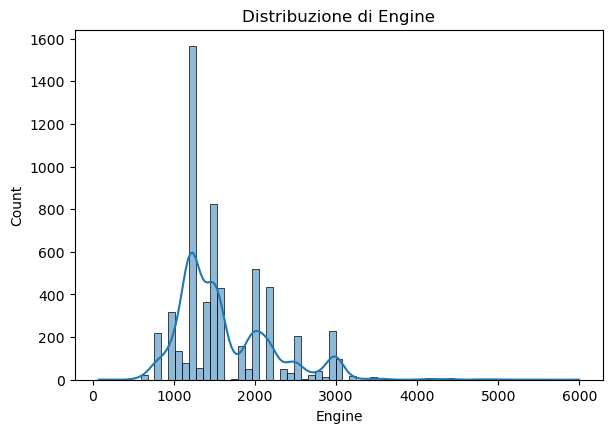

In [74]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.histplot(df['Engine'], kde=True)
plt.title('Distribuzione di Engine')

L'unica fatto da evidenziare qui, è quel minimo che è uguale a 72. Probabilmente l'auto elettrica.

In [75]:
df['Power'].describe()

count    5933.000000
mean      113.265754
std        53.359155
min        34.200000
25%        78.900000
50%        97.700000
75%       138.100000
max       560.000000
Name: Power, dtype: float64

In [76]:
df['Power'].mode()

0    74.0
Name: Power, dtype: float64

Text(0.5, 1.0, 'Distribuzione di Power')

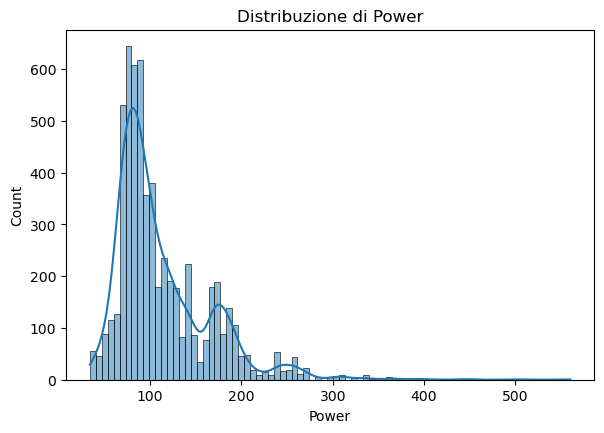

In [77]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.histplot(df['Power'], kde=True)
plt.title('Distribuzione di Power')

Questa è una distribuzione skewed a destra. Da notare come sia in qualche modo simile ad Engine, il che ha perfettamente senso

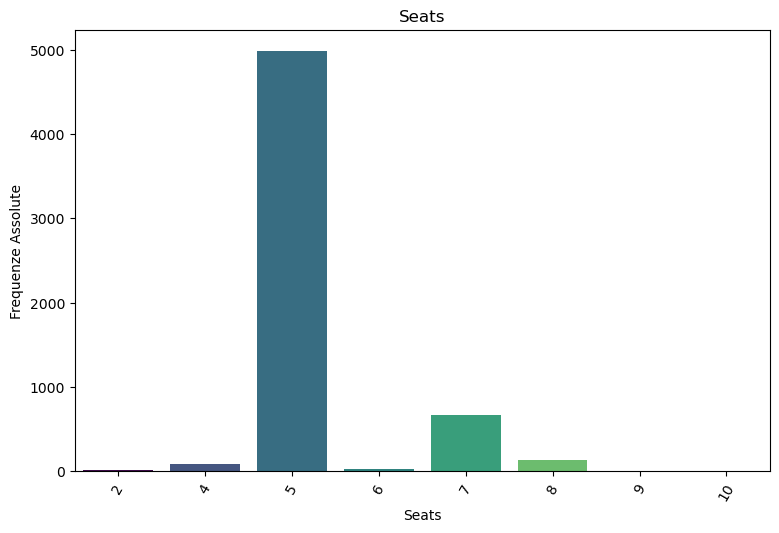

In [78]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
top_counts = df['Seats'].value_counts().head(15)
    
sns.barplot(x=top_counts.index, y=top_counts.values, hue=top_counts.index, palette='viridis', legend=False)
plt.title('Seats')
plt.xticks(rotation=60)
plt.ylabel('Frequenze Assolute')

plt.tight_layout()
plt.show()

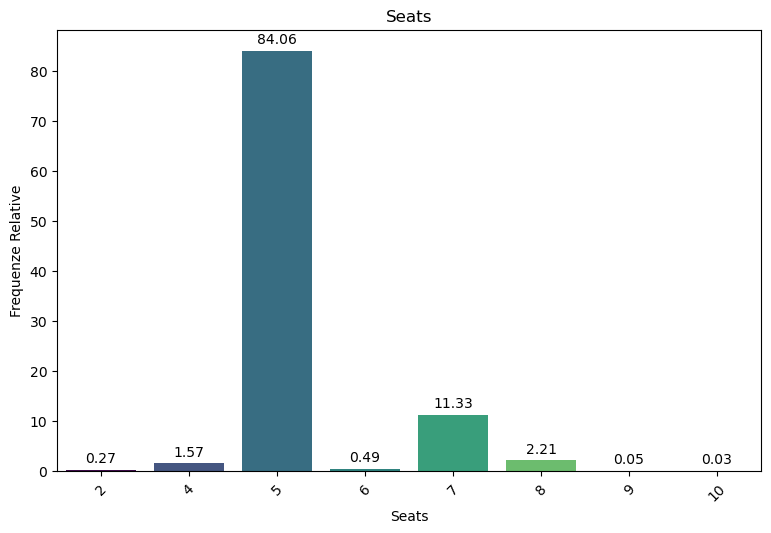

In [79]:
top_relative = df['Seats'].value_counts(normalize=True).head(15) * 100

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)

ax = sns.barplot(x=top_relative.index, y=top_relative.values, hue=top_relative.index, palette='viridis', legend=False)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.title('Seats')
plt.xticks(rotation=45)
plt.ylabel('Frequenze Relative')

plt.tight_layout()
plt.show()

Qui va bene anche lasciarla così, nonostante il monopolio delle auto a 5 posti. Questo perché la variabile è numerica e non richiede encoding.

In [80]:
df['Price'].describe()

count    5933.000000
mean        9.579852
std        11.204936
min         0.500000
25%         3.500000
50%         5.700000
75%        10.000000
max       160.000000
Name: Price, dtype: float64

In [81]:
df['Price'].mode()

0    4.5
Name: Price, dtype: float64

Text(0.5, 1.0, 'Distribuzione di Price')

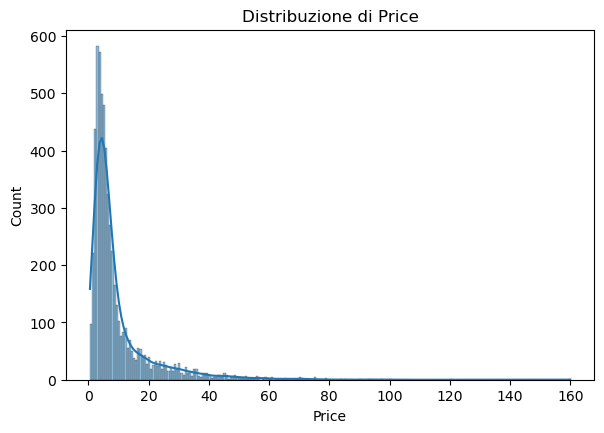

In [82]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.histplot(df['Price'], kde=True)
plt.title('Distribuzione di Price')

Troppo right skewed. Necessaria una trasformazione logaritmica.

In [83]:
df['Price'] = np.log1p(df['Price'])

Text(0.5, 1.0, 'Distribuzione di Price')

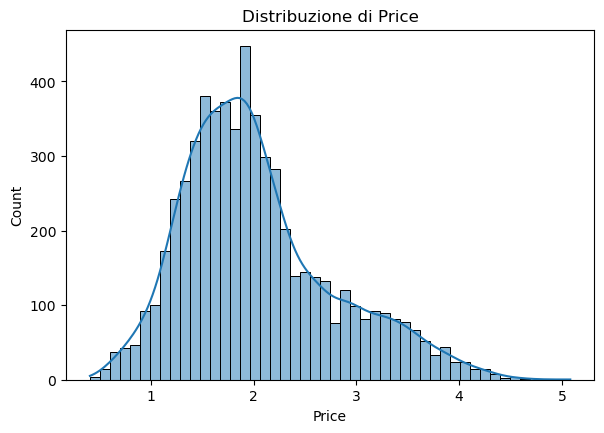

In [84]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 2)
sns.histplot(df['Price'], kde=True)
plt.title('Distribuzione di Price')

Ora sistemiamo pure le altre variabili che avevamo detto.

In [85]:
df = df[df['Fuel_Type'].isin(['Diesel', 'Petrol'])].copy()

df['Owner_Type'] = df['Owner_Type'].replace('Fourth & Above', 'Third')

model_counts = df['Model'].value_counts()
rare_models = model_counts[model_counts < 10].index
df['Model'] = df['Model'].replace(rare_models, 'Other')

df['Brand'] = df['Brand'].replace({'ISUZU': 'Isuzu', 'Land': 'Land Rover'})
brand_counts = df['Brand'].value_counts()
rare_brands = brand_counts[brand_counts < 60].index

luxury_list = [
    'Lamborghini', 'Bentley', 'Porsche', 'Jaguar', 'Land Rover', 
    'Mini', 'Volvo', 'Mercedes-Benz', 'Audi', 'BMW', 'Lexus'
]

def clean_brand_smart(brand):
    if brand not in rare_brands:
        return brand
    else:
        if brand in luxury_list:
            return 'Other_Luxury' 
        else:
            return 'Other'         

df['Brand'] = df['Brand'].apply(clean_brand_smart)

# Verifica Finale
print("Distribuzione Brand dopo il raggruppamento:")
print(df['Brand'].value_counts())
df.reset_index(drop=True, inplace=True)

Distribuzione Brand dopo il raggruppamento:
Brand
Maruti           1124
Hyundai          1086
Honda             599
Toyota            402
Volkswagen        315
Mercedes-Benz     313
Ford              296
Mahindra          269
BMW               266
Audi              236
Tata              181
Skoda             170
Other_Luxury      166
Renault           145
Chevrolet         120
Nissan             91
Other              86
Name: count, dtype: int64


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5865 entries, 0 to 5864
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5865 non-null   object 
 1   Model              5865 non-null   object 
 2   Location           5865 non-null   object 
 3   Age                5865 non-null   int64  
 4   Kilometers_Driven  5865 non-null   float64
 5   Fuel_Type          5865 non-null   object 
 6   Transmission       5865 non-null   object 
 7   Owner_Type         5865 non-null   object 
 8   Mileage            5865 non-null   float64
 9   Engine             5865 non-null   int64  
 10  Power              5865 non-null   float64
 11  Seats              5865 non-null   int64  
 12  Price              5865 non-null   float64
dtypes: float64(4), int64(3), object(6)
memory usage: 595.8+ KB


In [87]:
df.head()

,Brand,Model,Location,Age,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Hyundai,Creta,Pune,4,41000.0,Diesel,Manual,First,19.67,1582,126.20,5,2.602690
1,Honda,Jazz,Chennai,8,46000.0,Petrol,Manual,First,18.20,1199,88.70,5,1.704748
2,Maruti,Ertiga,Chennai,7,87000.0,Diesel,Manual,First,20.77,1248,88.76,7,1.945910
3,Audi,A4,Coimbatore,6,40670.0,Diesel,Automatic,Second,15.20,1968,140.80,5,2.930660
4,Nissan,Micra,Jaipur,6,86999.0,Diesel,Manual,First,23.08,1461,63.10,5,1.504077


Ci siamo perfetto, ora il dataset è pronto ed pulito per bene. Finora abbiamo fatto:  
- Data Cleaning (Valori nulli, unità di misura).  
- Feature Engineering (Age, log per Price).  
- Feature Reduction (Raggruppamento Brand e Owner).  
- Analisi Univariata (Verifica distribuzioni).  

In [88]:
df.to_csv('dataframe.csv', index=False)

**Analisi multivariata**  
Iniziamo per ordine pure qui. Numerica vs Numerica.

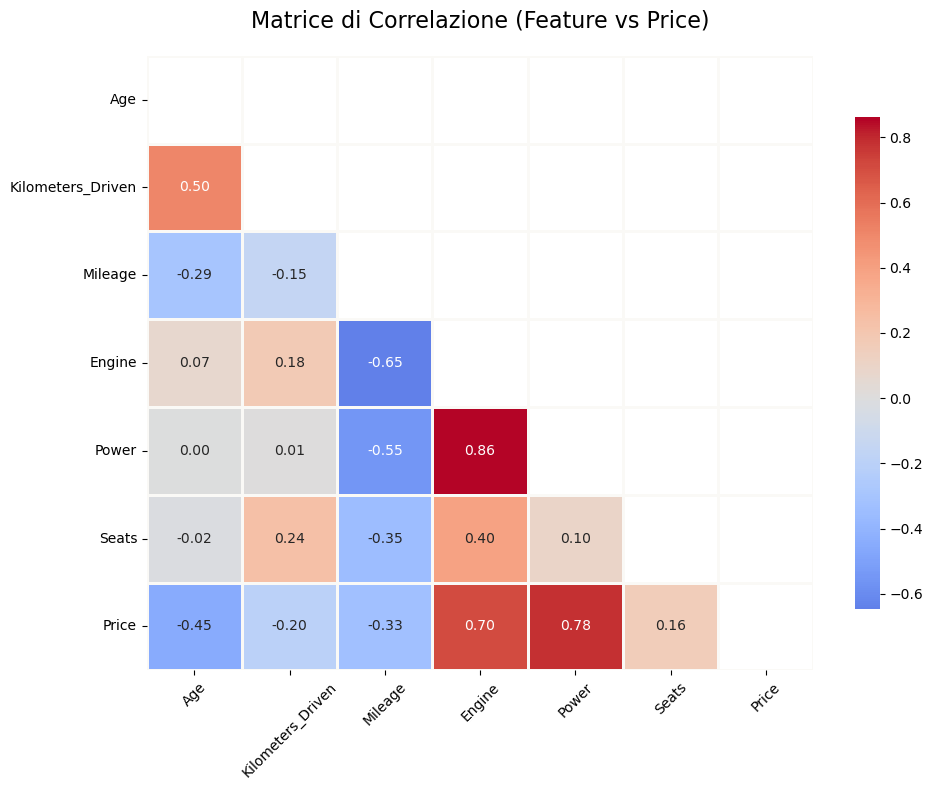

In [89]:
plt.figure(figsize=(10, 8))
numeric_cols = ['Age', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,        
            fmt=".2f",         
            cmap='coolwarm',   
            center=0,          
            linewidths=1,      
            linecolor='#FAF9F6', 
            cbar_kws={"shrink": .8})

plt.title('Matrice di Correlazione (Feature vs Price)', fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

(Power 0.78, Engine 0.70): Sono correlazioni fortissime. Significa che la potenza è il miglior predittore del prezzo. Se l'auto ha tanti cavalli, costa tanto.

L'Invecchiamento (Age -0.45): Correlazione negativa solida. Ogni anno che passa, il prezzo scende. Perfetto.

(Mileage -0.33): È negativo. Significa che più l'auto è efficiente (fa tanti km con un litro), meno costa. Perché? Perché le auto che consumano poco sono le utilitarie economiche (Maruti). Le auto che consumano molto sono le Ferrari e i SUV di lusso. Quindi ha senso!

Multicollinearità (Engine vs Power = 0.86) Il quadratino rosso scuro tra Engine e Power. 0.86 è altissimo. Significa che queste due variabili dicono quasi la stessa cosa (motore grosso = tanta potenza).

Soluzione futura: Se il modello vacilla, potremmo doverne eliminare una delle due (di solito si tiene Power perché 0.78 > 0.70).

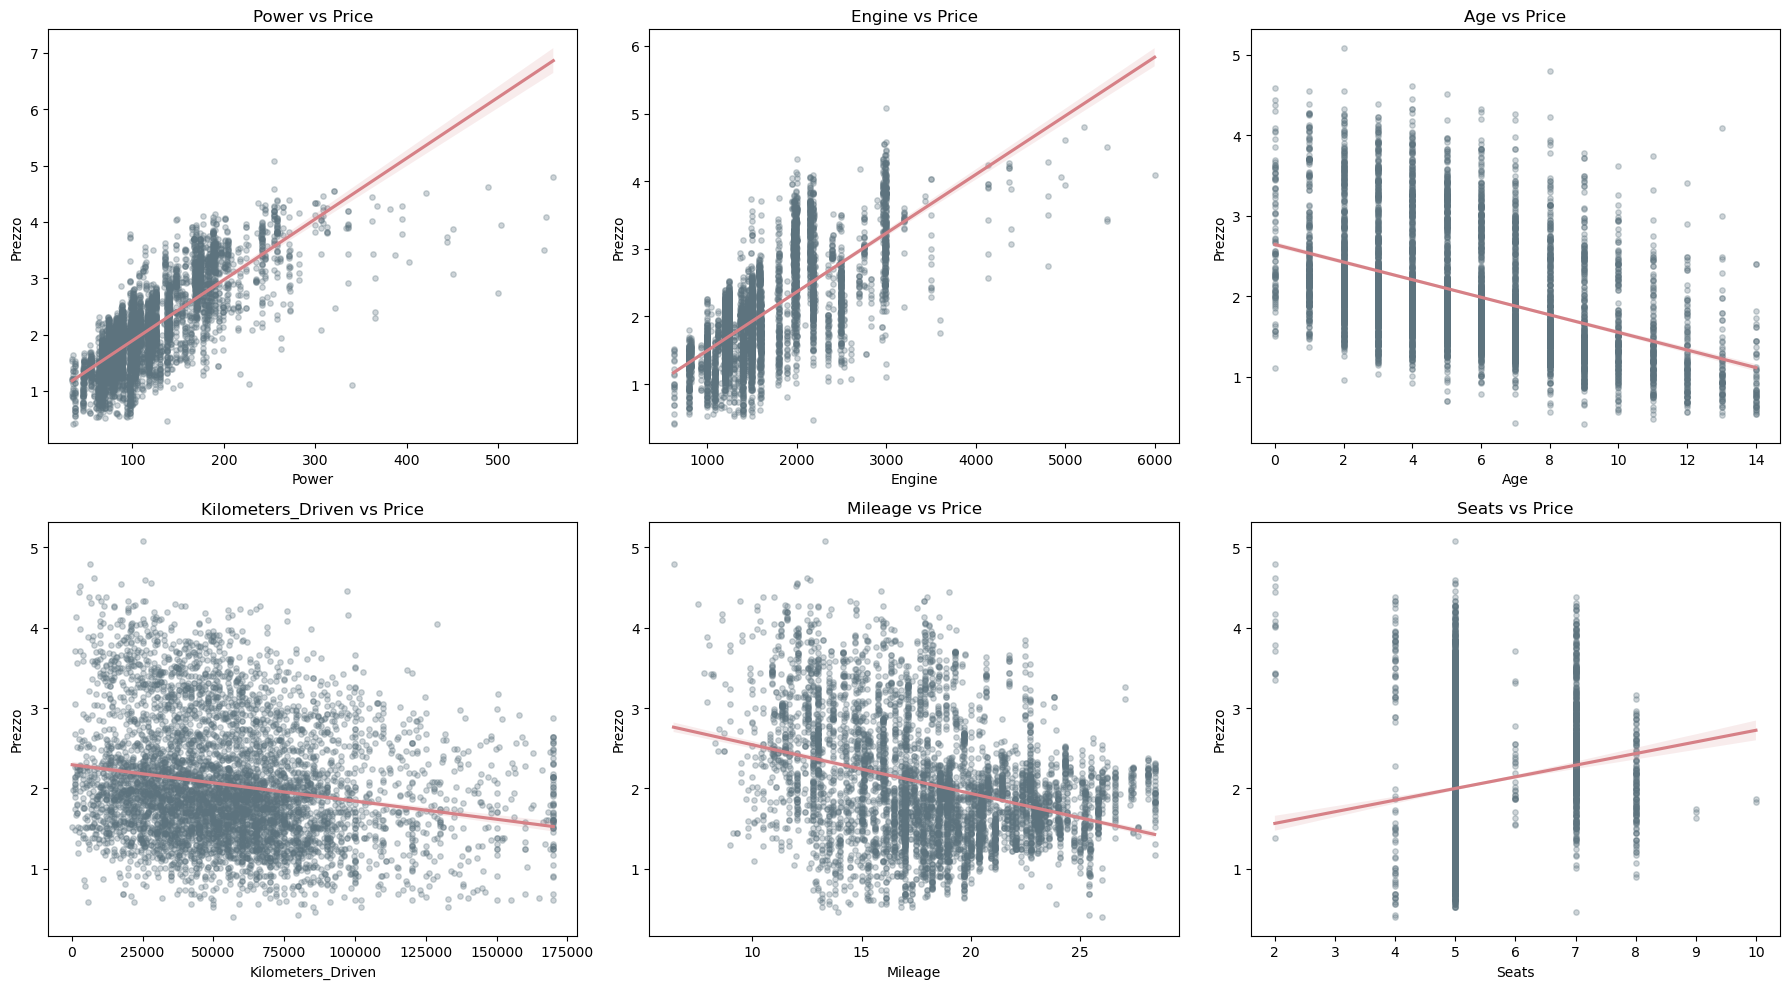

In [90]:
vars_to_plot = ['Power', 'Engine', 'Age', 'Kilometers_Driven', 'Mileage', 'Seats'] 

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes = axes.flatten()

for i, col in enumerate(vars_to_plot):
    sns.regplot(x=col, y='Price', data=df, ax=axes[i],
                scatter_kws={'color': '#5D737E', 'alpha': 0.3, 's': 15}, 
                line_kws={'color': '#D68086'}) 
    
    axes[i].set_title(f'{col} vs Price', fontsize=12)
    axes[i].set_ylabel('Prezzo')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

Questi sono tutti pattern lineari. Perfetto

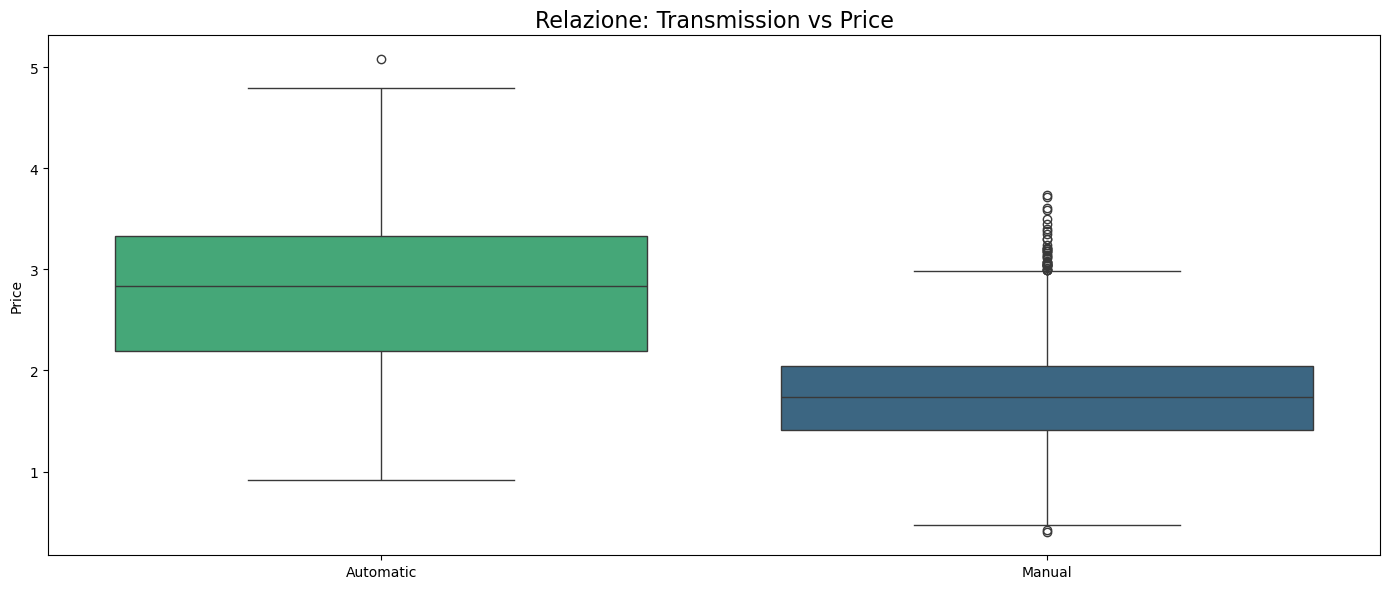

Statistiche per TRANSMISSION:
              count  mean  median   std
Transmission                           
Automatic      1708  2.77    2.83  0.75
Manual         4157  1.74    1.74  0.48


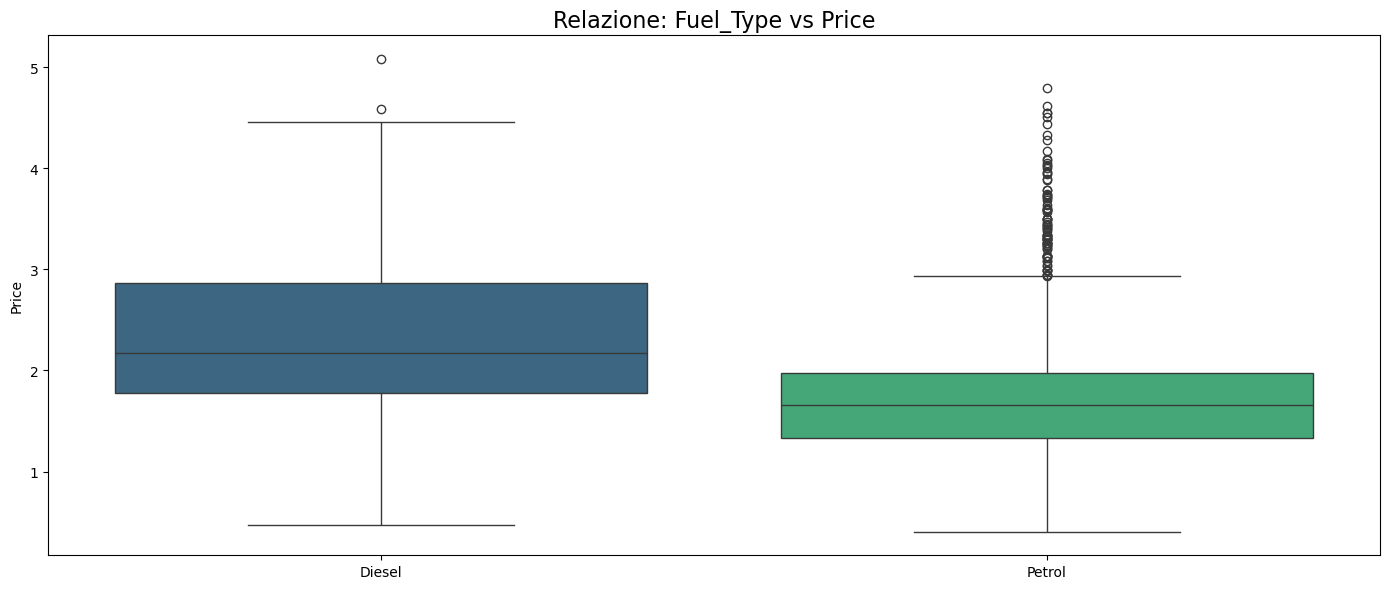

Statistiche per FUEL_TYPE:
           count  mean  median   std
Fuel_Type                           
Diesel      3186  2.32    2.17  0.75
Petrol      2679  1.70    1.65  0.57


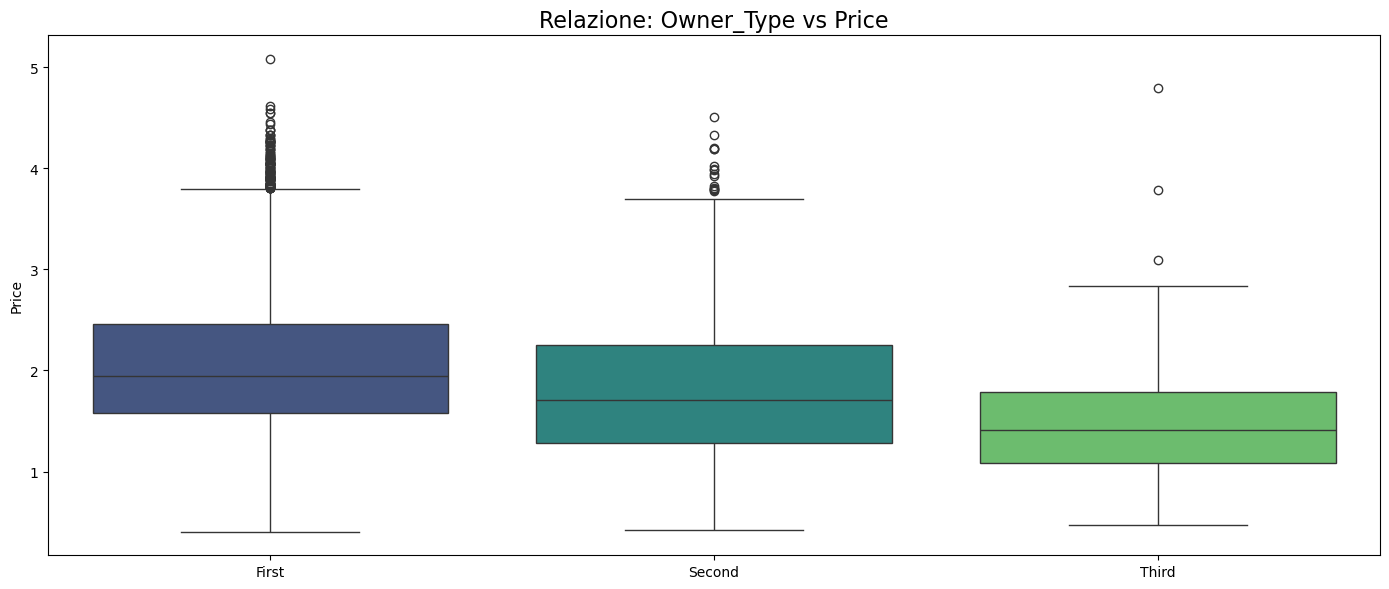

Statistiche per OWNER_TYPE:
            count  mean  median   std
Owner_Type                           
First        4844  2.09    1.94  0.73
Second        920  1.84    1.70  0.76
Third         101  1.51    1.41  0.68


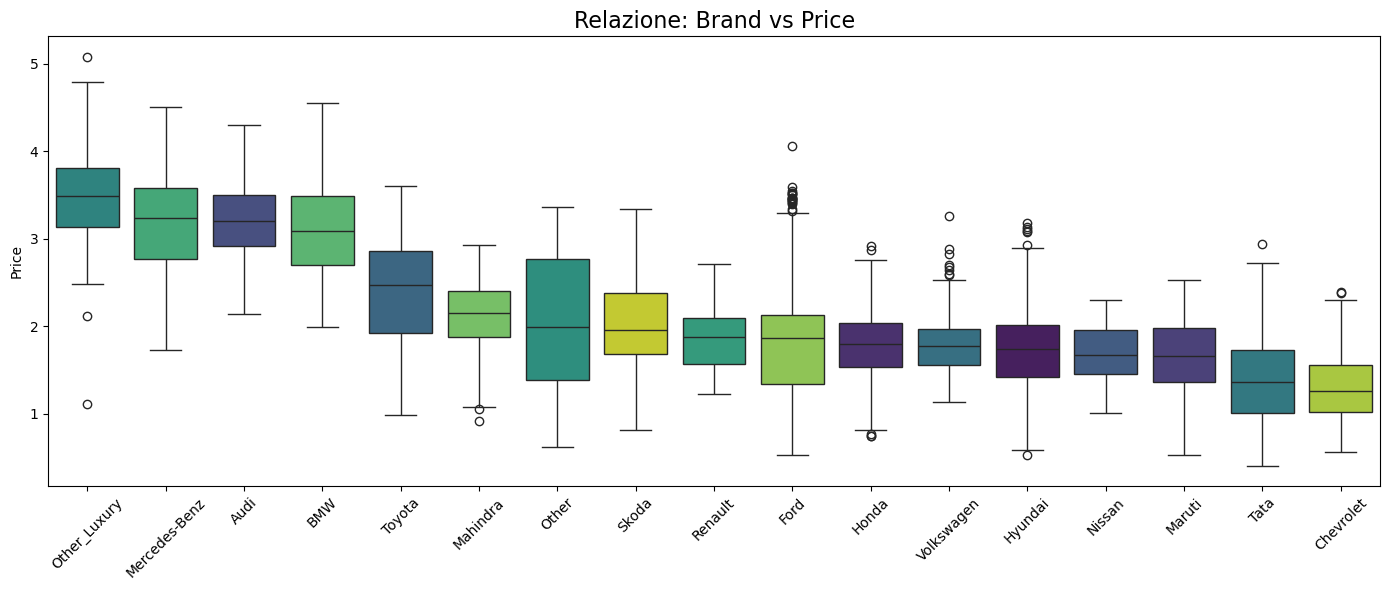

Statistiche per BRAND:
               count  mean  median   std
Brand                                   
Other_Luxury     166  3.48    3.49  0.53
Mercedes-Benz    313  3.19    3.24  0.55
Audi             236  3.18    3.20  0.45
BMW              266  3.11    3.09  0.54
Toyota           402  2.39    2.47  0.58
Mahindra         269  2.12    2.15  0.42
Other             86  2.04    1.99  0.74
Skoda            170  2.01    1.95  0.53
Renault          145  1.86    1.87  0.33
Ford             296  1.83    1.86  0.64
Honda            599  1.80    1.79  0.37
Volkswagen       315  1.78    1.77  0.32
Hyundai         1086  1.75    1.74  0.47
Nissan            91  1.70    1.67  0.31
Maruti          1124  1.65    1.66  0.42
Tata             181  1.39    1.36  0.51
Chevrolet        120  1.32    1.25  0.40


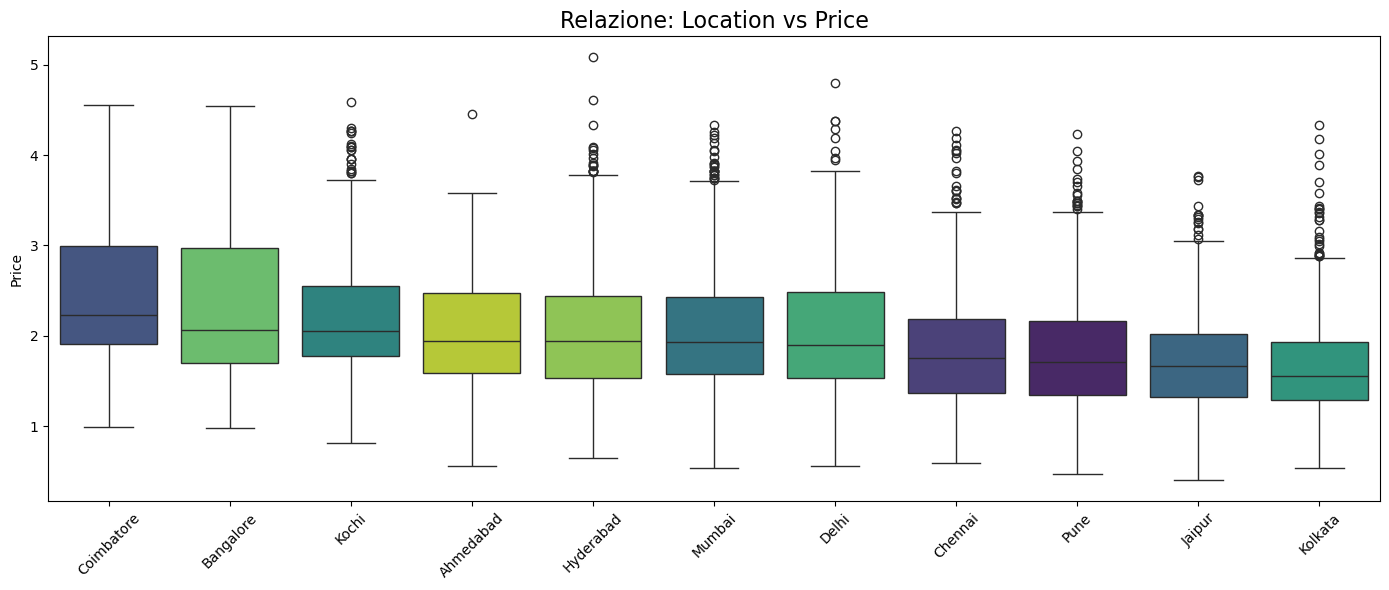

Statistiche per LOCATION:
            count  mean  median   std
Location                             
Coimbatore    634  2.46    2.23  0.76
Bangalore     355  2.31    2.07  0.81
Kochi         641  2.23    2.05  0.68
Ahmedabad     219  2.03    1.95  0.64
Hyderabad     724  2.07    1.94  0.73
Mumbai        763  2.07    1.93  0.71
Delhi         544  2.07    1.90  0.73
Chennai       470  1.88    1.75  0.71
Pune          588  1.81    1.70  0.68
Jaipur        396  1.73    1.67  0.63
Kolkata       531  1.67    1.56  0.59


In [91]:
cat_cols = ['Transmission', 'Fuel_Type', 'Owner_Type', 'Brand', 'Location']

for col in cat_cols:
    stat = df.groupby(col)['Price'].agg(['count', 'mean', 'median', 'std'])
    
    stat = stat.sort_values(by='median', ascending=False)
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(x=col, y='Price', data=df, order=stat.index, palette='viridis', hue=col)
    plt.title(f'Relazione: {col} vs Price', fontsize=16)
    plt.ylabel('Price')
    plt.xlabel('')
    
    if len(stat) > 5:
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()
    
    print(f"Statistiche per {col.upper()}:")
    print(stat.round(2))

Come si evince dai grafici, non si nota alcuna anomalia, e molti dei dati hanno tanto senso. Passiamo ora a categorica vs categorica.

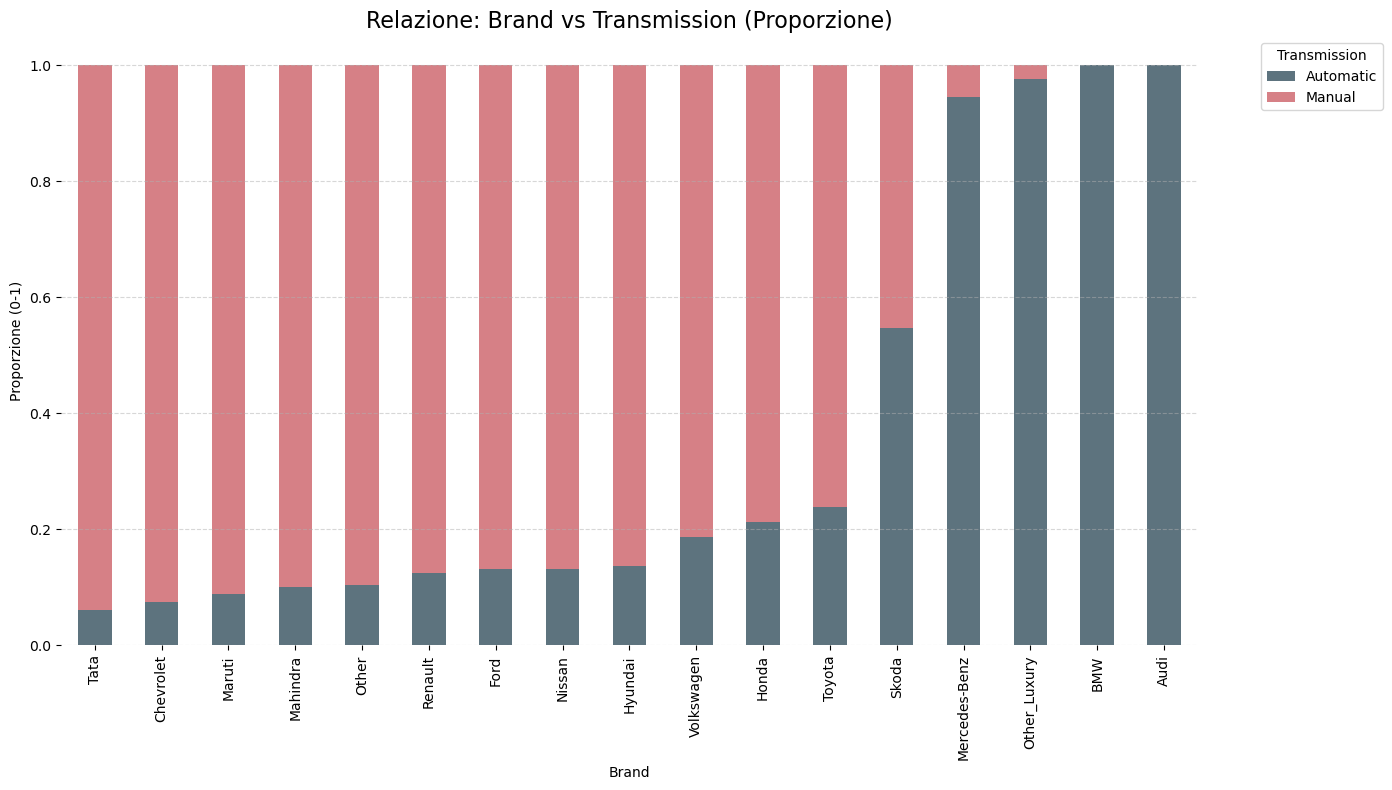

In [92]:
cat1 = 'Brand'
cat2 = 'Transmission'

cross_tab_prop = pd.crosstab(df[cat1], df[cat2], normalize='index')
cross_tab_prop = cross_tab_prop.sort_values(by='Automatic', ascending=True)

ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#5D737E', '#D68086'])

plt.title(f'Relazione: {cat1} vs {cat2} (Proporzione)', fontsize=16)
plt.ylabel('Proporzione (0-1)')
plt.xlabel(cat1)
plt.legend(title=cat2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.box(False)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [93]:
contingency_table = pd.crosstab(df['Brand'], df['Transmission'])

print("--- Tabella di Contingenza (Brand vs Transmission) ---")
print(contingency_table)
print("\n" + "="*50 + "\n")

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Statistica Chi-Quadro: {chi2:.2f}")
print(f"P-Value: {p:.4f}")

if p < 0.05:
    print("Risultato: Le variabili sono statisticamente DIPENDENTI (C'è relazione).")
else:
    print("Risultato: Le variabili sono INDIPENDENTI (Non c'è relazione).")

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramer_v = np.sqrt(chi2 / (n * min_dim))

print(f"V di Cramér (Forza della relazione 0-1): {cramer_v:.3f}")

--- Tabella di Contingenza (Brand vs Transmission) ---
Transmission   Automatic  Manual
Brand                           
Audi                 236       0
BMW                  266       0
Chevrolet              9     111
Ford                  39     257
Honda                128     471
Hyundai              148     938
Mahindra              27     242
Maruti                99    1025
Mercedes-Benz        296      17
Nissan                12      79
Other                  9      77
Other_Luxury         162       4
Renault               18     127
Skoda                 93      77
Tata                  11     170
Toyota                96     306
Volkswagen            59     256


Statistica Chi-Quadro: 2895.50
P-Value: 0.0000
Risultato: Le variabili sono statisticamente DIPENDENTI (C'è relazione).
V di Cramér (Forza della relazione 0-1): 0.703


Cioè quindi il modello vede che se l'auto è un'Audi, sa già al 99% che è automatica. L'informazione "Transmission=Automatic" diventa quasi ridondante.
Invece i brand "Full Manual" (sinistra): Tata, Chevrolet, Maruti, Mahindra. Sono quasi interamente rosa (Manuali).
Nonostante questo ci sono comunque dei marchi che stanno in mezzo, quindi è rilevante.

È vero che certi marchi (es. Maruti/Honda) sono quasi tutti a benzina, mentre i marchi di SUV/Lusso sono quasi tutti diesel?

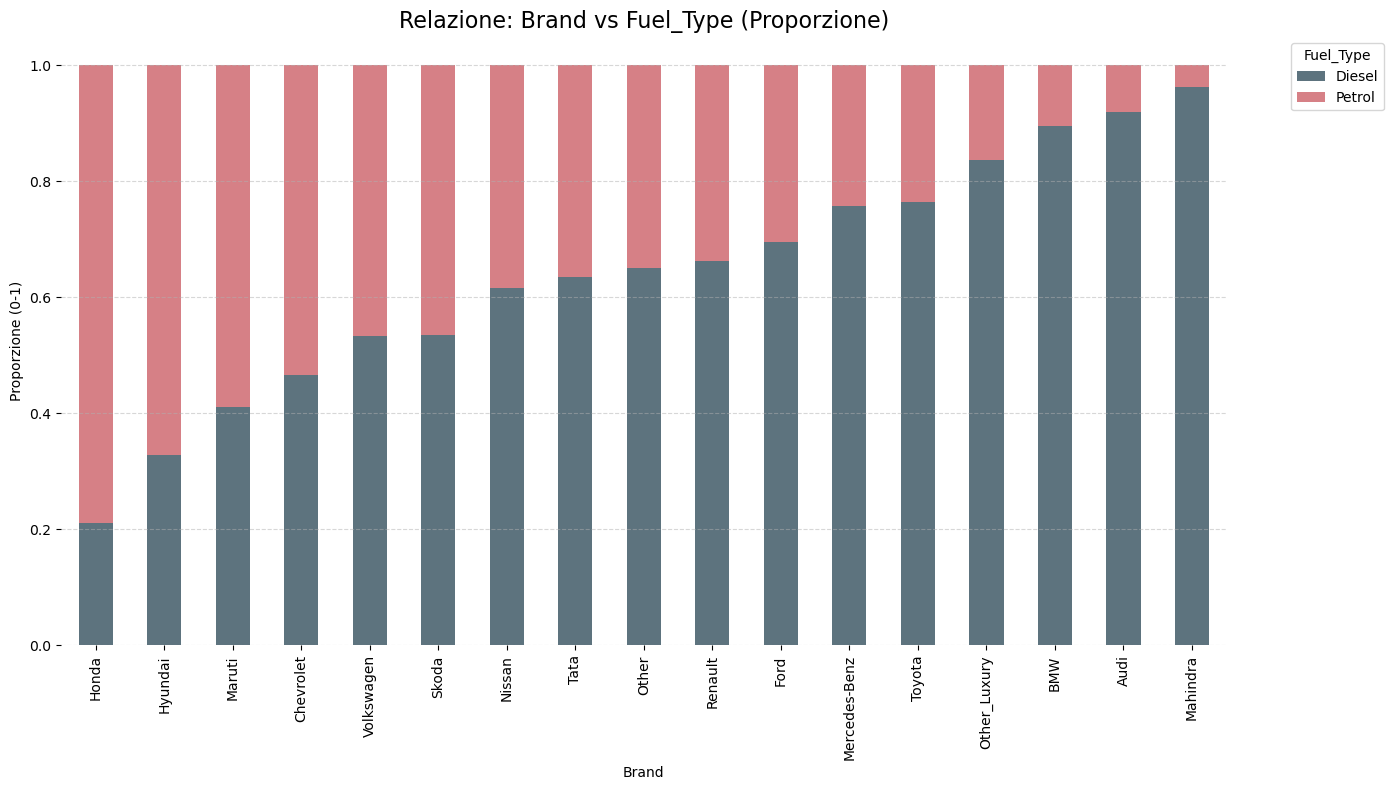

In [94]:
cat1 = 'Brand'
cat2 = 'Fuel_Type'

cross_tab_prop = pd.crosstab(df[cat1], df[cat2], normalize='index')
cross_tab_prop = cross_tab_prop.sort_values(by='Diesel', ascending=True)

ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#5D737E', '#D68086'])

plt.title(f'Relazione: {cat1} vs {cat2} (Proporzione)', fontsize=16)
plt.ylabel('Proporzione (0-1)')
plt.xlabel(cat1)
plt.legend(title=cat2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.box(False)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [95]:
contingency_table = pd.crosstab(df['Brand'], df['Fuel_Type'])

print("--- Tabella di Contingenza (Brand vs Fuel_Type) ---")
print(contingency_table)
print("\n" + "="*50 + "\n")

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Statistica Chi-Quadro: {chi2:.2f}")
print(f"P-Value: {p:.4f}")

if p < 0.05:
    print("Risultato: Le variabili sono statisticamente DIPENDENTI (C'è relazione).")
else:
    print("Risultato: Le variabili sono INDIPENDENTI (Non c'è relazione).")

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramer_v = np.sqrt(chi2 / (n * min_dim))

print(f"V di Cramér (Forza della relazione 0-1): {cramer_v:.3f}")

--- Tabella di Contingenza (Brand vs Fuel_Type) ---
Fuel_Type      Diesel  Petrol
Brand                        
Audi              217      19
BMW               238      28
Chevrolet          56      64
Ford              206      90
Honda             126     473
Hyundai           356     730
Mahindra          259      10
Maruti            463     661
Mercedes-Benz     237      76
Nissan             56      35
Other              56      30
Other_Luxury      139      27
Renault            96      49
Skoda              91      79
Tata              115      66
Toyota            307      95
Volkswagen        168     147


Statistica Chi-Quadro: 1252.25
P-Value: 0.0000
Risultato: Le variabili sono statisticamente DIPENDENTI (C'è relazione).
V di Cramér (Forza della relazione 0-1): 0.462


Sapere il Brand ti aiuta molto a indovinare il carburante, ma non sempre. I brand di SUV sono quasi solo diesel.

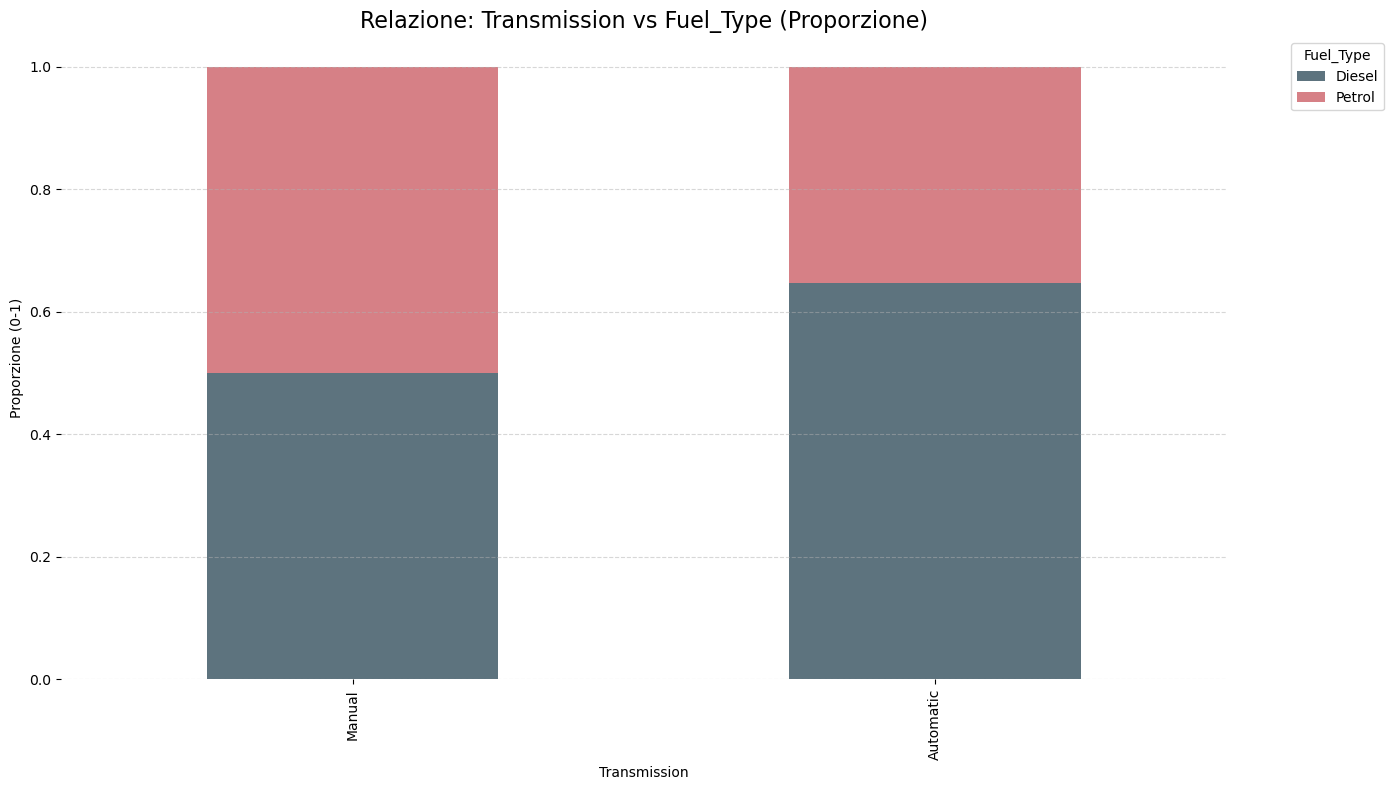

In [96]:
cat1 = 'Transmission'
cat2 = 'Fuel_Type'

cross_tab_prop = pd.crosstab(df[cat1], df[cat2], normalize='index')
cross_tab_prop = cross_tab_prop.sort_values(by='Diesel', ascending=True)

ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(14, 8), color=['#5D737E', '#D68086'])

plt.title(f'Relazione: {cat1} vs {cat2} (Proporzione)', fontsize=16)
plt.ylabel('Proporzione (0-1)')
plt.xlabel(cat1)
plt.legend(title=cat2, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.box(False)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [97]:
contingency_table = pd.crosstab(df['Transmission'], df['Fuel_Type'])

print("--- Tabella di Contingenza (Transmission vs Fuel_Type) ---")
print(contingency_table)
print("\n" + "="*50 + "\n")

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Statistica Chi-Quadro: {chi2:.2f}")
print(f"P-Value: {p:.4f}")

if p < 0.05:
    print("Risultato: Le variabili sono statisticamente DIPENDENTI (C'è relazione).")
else:
    print("Risultato: Le variabili sono INDIPENDENTI (Non c'è relazione).")

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramer_v = np.sqrt(chi2 / (n * min_dim))

print(f"V di Cramér (Forza della relazione 0-1): {cramer_v:.3f}")

--- Tabella di Contingenza (Transmission vs Fuel_Type) ---
Fuel_Type     Diesel  Petrol
Transmission                
Automatic       1105     603
Manual          2081    2076


Statistica Chi-Quadro: 103.91
P-Value: 0.0000
Risultato: Le variabili sono statisticamente DIPENDENTI (C'è relazione).
V di Cramér (Forza della relazione 0-1): 0.133


C'è una relazione molto debole. Il modello ha bisogno di entrambe le colonne per capire il prezzo. 

Con questo concludiamo **EDA** e passiamo all'inferenza statistica.

**Inferenza Statistica**

C'è una differenza statisticamente significativa nel prezzo medio tra auto automatiche e manuali, o la differenza osservata è frutto del caso?

In [98]:
prices_auto = df[df['Transmission'] == 'Automatic']['Price']
prices_manual = df[df['Transmission'] == 'Manual']['Price']

print("--- ANALISI INTERVALLI DI CONFIDENZA ---")

print("\n[Gruppo: Automatic]")
mean_a = prices_auto.mean()
std_a = np.std(prices_auto)
n_a = len(prices_auto)
standard_error_a = std_a / np.sqrt(n_a)
confidence_level = 0.95

interval_a = stats.norm.interval(confidence_level, loc=mean_a, scale=standard_error_a)

print(f"Media stimata: {mean_a:0.2f}")
print(f"Deviazione standard del sample: {std_a:0.2f}")
print(f"Deviazione standard del sample: {standard_error_a:0.2f}")
print(f"Intervallo di confidenza (95%): [{interval_a[0]:0.2f}, {interval_a[1]:0.2f}]")


print("\n[Gruppo: Manual]")
mean_m = prices_manual.mean()
std_m = np.std(prices_manual)
n_m = len(prices_manual)
standard_error_m = std_m / np.sqrt(n_m)

interval_m = stats.norm.interval(confidence_level, loc=mean_m, scale=standard_error_m)

print(f"Media stimata: {mean_m:0.2f}")
print(f"Deviazione standard del sample: {std_m:0.2f}")
print(f"Deviazione standard del sample: {standard_error_m:0.2f}")
print(f"Intervallo di confidenza (95%): [{interval_m[0]:0.2f}, {interval_m[1]:0.2f}]")


print("\n" + "="*50 + "\n")
print("--- TWO SAMPLE T-TEST ---")


alpha = 0.05

t_stat, p_value = stats.ttest_ind(prices_auto, prices_manual)

print(f"Test statistic: {t_stat:0.2f}")
print(f"Significance level: {alpha:0.2f}")

print(f"P-value: {p_value:.10f}") 

if p_value < alpha:
    print("Conclusione: Ipotesi nulla rifiutata.")
    print("C'è una significante differenza tra il prezzo medio e le auto Automatic e Manual.")
else:
    print("Conclusione: Non si può rifiutare l'ipotesi nulla.")
    print("Non c'è una differenza significativa tra il prezzo medio e le auto Automatic e Manual.")

--- ANALISI INTERVALLI DI CONFIDENZA ---

[Gruppo: Automatic]
Media stimata: 2.77
Deviazione standard del sample: 0.75
Deviazione standard del sample: 0.02
Intervallo di confidenza (95%): [2.74, 2.81]

[Gruppo: Manual]
Media stimata: 1.74
Deviazione standard del sample: 0.48
Deviazione standard del sample: 0.01
Intervallo di confidenza (95%): [1.73, 1.76]


--- TWO SAMPLE T-TEST ---
Test statistic: 62.65
Significance level: 0.05
P-value: 0.0000000000
Conclusione: Ipotesi nulla rifiutata.
C'è una significante differenza tra il prezzo medio e le auto Automatic e Manual.


Esiste una dipendenza statistica tra il segmento del Brand (Economico vs Lusso) e il tipo di Trasmissione offerta, o la distribuzione tra Manuale e Automatico è casuale tra i vari marchi?

In [99]:
contingency_table = pd.crosstab(df['Brand'], df['Transmission']) 

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramer_v = (chi2 / (n * min_dim))**0.5

print(f"Chi-square statistic: {chi2:.2f}")
print(f"Cramer V statistic: {cramer_v:.2f}")
print(f"p-value: {p:.10f}")

alpha = 0.05
if p < alpha:
    print("\nC'è una significante associazione tra Brand e Transmission.")
else:
    print("\nNon c'è una significante associazione tra Brand e Transmission.")

Chi-square statistic: 2895.50
Cramer V statistic: 0.70
p-value: 0.0000000000

C'è una significante associazione tra Brand e Transmission.


La popolazione della variabile target Price, segue una distribuzione Gaussiana?

In [100]:
statistic, p_value = normaltest(df['Price'])

alpha = 0.05

print(f"Test statistic: {statistic:.2f}")
print(f"P-value: {p_value:.10f}")

if p_value > alpha:
    print("E' Gaussiano. L'ipotesi H0 è vera.")
else:
    print("H0 rifiutata")

Test statistic: 494.81
P-value: 0.0000000000
H0 rifiutata


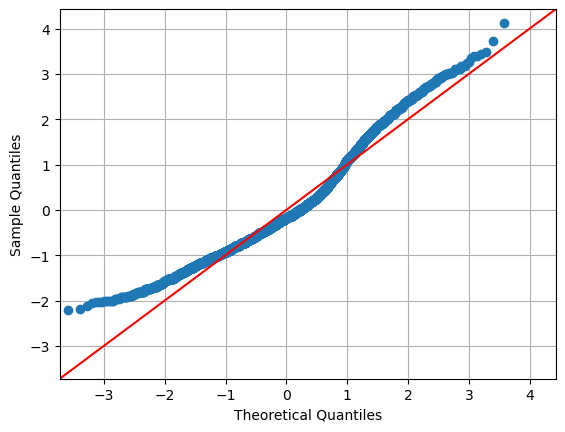

In [101]:
qqplot(df['Price'], fit=True, line='45')
plt.grid()
plt.show()

Come si evince dal grafico, la nostra variabile segue, o comunque tende ad una Gaussiana. 